# **Milestone 5: Classifying Bird Song in Europe**

Group 4: Sandra Forro, Imran Naskani, Erin Rebholz

# **Table of Contents**


1. [Problem Statement](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=XgeM1aqw0xnM&line=1&uniqifier=1)

2. [Dataset Background and Sample Selection](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=I3dkmWakRDmi&line=1&uniqifier=1)

3. [Audo Processing Refinement](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=CYBb8WpB1JZE&line=1&uniqifier=1)

4. [Image Data Generator Functions](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=2SUvFfjiSDnv&line=1&uniqifier=1)

5. [Model Selection and Testing](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=62d4f240-942c-4a14-9b2b-cbd41182949d&line=6&uniqifier=1)

6. [Results Interpretation and Analysis](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=09NZgNQG1mqa&line=1&uniqifier=1)

7. [Summary of Findings and Future Next Steps](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=kmg9XdHM3sFf&line=1&uniqifier=1)


[APPENDIX 1:  Top 10 Bird Songs, and Top 80 Bird Calls](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=tTb0M98mY9p2&line=1&uniqifier=1)

[APPENDIX 2:  Additional Sample Augmentation with Call and Song for Top 10 Song bird (SANDRA)](https://colab.research.google.com/drive/1vBGZikFqfTCKsfvCLe0lyWRzqFAux4Xa#scrollTo=STYbUCE_wrRa&line=1&uniqifier=1)


### **0. Imports and Initialization**

In [ ]:
!pip install tensorflow-io==0.36.0  #Note 0.37.0 default version is no longer compatible

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.37.0
    Uninstalling tensorflow-io-gcs-filesystem-0.37.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.0


In [ ]:
#!pip install numba

In [ ]:
#!pip install librosa

In [ ]:
#Utilities
import os
import time
import pathlib
import requests

#General
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from random import sample

#Multimedia
import imageio  #image utility
from scipy.io import wavfile  #wav image utility
import matplotlib.image as mpimg  #image utility
from PIL import Image
import librosa  #mp3 utility
from IPython.display import Audio
from scipy.io.wavfile import read, write

#tensor_flow
import gc #To clear unused memory
import pickle

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#model basics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# More tensor flow packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D,  UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [ ]:
# Check if GPU is available and visible to TensorFlow
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


**Setting paths to access data file**

In [ ]:
#For google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

#Define base path with locations of text files
#Erin's
#base_path = "/content/drive/My Drive/Harvard_colab/CS109B/data/"  #colab
#base_path = r"G:/My Drive/Harvard_colab/CS109B/data"  #local from windows
#base_path = "/mnt/g/My Drive/Harvard_colab/CS109B/data/"  #local from WSL to g drive

#Sandra's
#base_path = '/content/drive/MyDrive/New Folder/CS109B/data'

#Imran's
#base_path = '/content/drive/MyDrive/CS109B/data'


# **1. Problem Statement**

The aim of this project is to **Classify Top Bird Songs in Europe**. 2,901 15 second song recordings of the top 10 European bird species were subsetted from the Xeno-canto (XC), the Foundation for Nature Sounds in the Netherlands. The number of samples are approximately 200 per bird type, with small upward or downward deviations. This project is inspired by the Nature and Biodiversity Conservation Union (NABU)'s paid bird song detection app, which is being foregone by users for the slower, manual process of sending recordings to a bird expert via WhatsApp instead. Success is defined as surpassing the 85% accuracy of the app.

The analysis below follows the following general process:

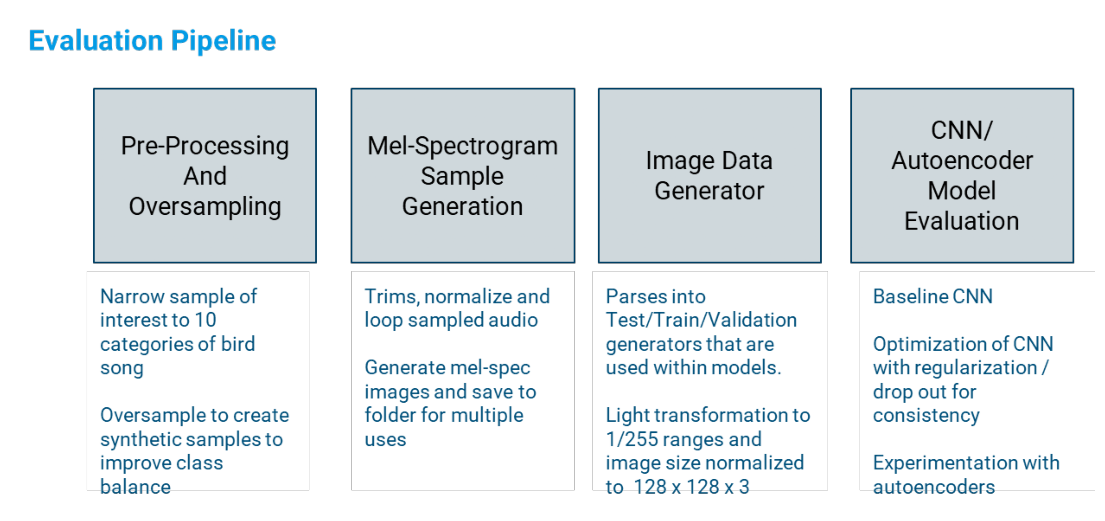

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/eval_pipe.png'))
plt.figure(figsize=(14, 10))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

# **2.  Dataset Background and Sample Selection**


## **2.1 Data Acquisition**
The dataset is acquired from Global Biodiversity Information Facility's website: https://www.gbif.org/dataset/b1047888-ae52-4179-9dd5-5448ea342a24

This data shared by GBIF is infact a subset of the entire collection of the Bird sound collection of Xeno-canto (XC), the Foundation for Nature Sounds in the Netherlands, available at https://xeno-canto.org/?gid=1. There are more than 700k occurences of bird sound recordings, verified and shared by Xeno-canto. This particular subset only comprises recordings whose recordists have given explicit sharing permission. Though recordings with a 'questioned' status (to indicate quality review) are included in the data set, the corresponding audio file is not available. We will remove those accordingly.

Data acquisition is done in two steps. GBIF has publised several text files which contain information about the bird species/subspecies/generic names, the location and time of occurence, and the download link of their audio recordings (amongst others). In the first step, we acquired these text files from the GBIF's website and then downloaded the audios using the links provided in the text files.

However, the total data is more than 700k, which is huge and cannot be downloaded in bulk since each audio file has its separate downlaod link, making the download sequential and more time consuming. **_Therefore, in the interest of scalability of this project, we have decided to use audio occurences only from the EUROPE region and the duration of audio clip to be less than or equal to 15 seconds._** EDA confirmed that this is a valid scope: longer recordings start to form a long tail in the duration distribution, and Europe has the most data.

For collaboration, we have set up this notebook as well as all the acquired data on Google Colab, but for the purpose of submission, we are running this notebook on the same data stored locally.

The main files of our interest which were acquired from GBIF's website are:
- multimedia.txt
- occurrence.txt
- meta.xml

#### **2.a.1. multimedia.txt**

This file contains information about the occurence and the link to download the audio. It has 15 fields; 7 fields are blank but are not needed (metadata). The main fields which we selected from this file are unique ID, type, format, identifier and description of the occurences. These fields are merged with selected fields of occurrence.txt later to use as a final dataframe for exploration. Since we are modeling audio clips, we have applied a filter on the 'type' field to select ony 'Sound' based observations. A look at the images revealed that they are not sufficiently pre-processed or standardized enough for our needs.

Following are details of all the fields:

    - gbifID: Unique GBIF ID
    - type: Occurrence Type; Sound or Image
    - format: Occurrence Format; mpeg or wave in case of audio file; png in case of image
    - identifier: Link to download of the audio recording/image
    - references: (Blank)
    - title: (Blank)
    - description: Describes the length of audio in seconds either in audio or image.
    - source: (Blank)
    - audience: (Blank)
    - created: (Blank)
    - creator: Publisher of the bird sound (Xeno)
    - contributor: (Blank)
    - publisher: (Blank)
    - license: Lincensing information
    - rightsHolder: Copy rights information



In [ ]:
#### Open multi_df file and isolate useful fields
multi_df = pd.read_csv(os.path.join(base_path, 'multimedia.txt'), delimiter = "\t")

# Creating a multimedia df with selected fields
multi_selected_df = multi_df[multi_df['type'] == 'Sound'][['gbifID','type','format','identifier','description']]

# Creating a multimedia df with selected fields
multi_selected_df = multi_df[multi_df['type'] == 'Sound'][['gbifID','type','format','identifier','description']]

# Converting the duration in 'description' field from string to float.
multi_selected_df['duration_seconds'] = multi_selected_df['description'].str.replace(" s", "").astype(float)
multi_selected_df.head(3)

gbifID   type      format  \
0  2243549892  Sound  audio/mpeg   
5  2243549897  Sound  audio/mpeg   
6  2243549900  Sound  audio/mpeg   

                                          identifier description  \
0  https://xeno-canto.org/sounds/uploaded/OXSIOLJ...         3 s   
5  https://xeno-canto.org/sounds/uploaded/RJNSQXB...         7 s   
6  https://xeno-canto.org/sounds/uploaded/PWDLINY...        47 s   

   duration_seconds  
0               3.0  
5               7.0  
6              47.0

#### **2.a.2 occurence.txt**

This file mainly contains demographic, species' scientific identification, licensing and miscellaneous information with a lot of blank fields. After reviewing this file, we decided to use only selected fields which were useful for our purpose and objective.

We see missing data in some of these fields; details are shown below in the output of .info(). However, this missingness is not a roadblock. No imputation is used - enough data is available and filtered accordingly. Since we will be focusing on audio data rather than tabular data, columns with high missingness, such as as `sex`, can just serve as additional information when available. The column `associatedTaxa` has a high missing rate, yet it denotes occurences with background noise/other birds. Thus, the missingness in `associatedTaxa` shown below signifies that 33% of recordings have multiple birds singing. The only other concerning missing value rate is for level3Name, which characterizes cities. We can use geographic coordinates instead (if applicable).

There are some fields that will not be kept but are necessary as filters. These are` year` (the data ranges back to the 1800s) and `identificationRemarks`, which characterize observations where the classification is subject to review. According to the GBIF website, these should not have any associated multimedia, but we will filter them out to be certain.


Following are the selected fields of our interest from occurence.txt:

    - gbifID: Unique GBIF ID
    - collectionCode: Shows the collection of this wildlife sound occurence; BIRDS in this data
    - basisOfRecord: Whether the observation is human recorded or machine recorded
    - behavior: Type of sound i.e. song, call, flight call, two birds singing, wing beats, etc. Behavior exhibited at the time of recording.
    - associatedTaxa: Determines whether background noise exists or not, particularly which other birds are detected in the background
    - continent: Continent of occurence
    - countryCode: Initials of Country of occurence
    - verbatimElevation: Geographic elevation of occurence
    - decimalLatitude: Geographic Latitude of occurence
    - decimalLongitude: Geographic Longitude of occurence
    - scientificName: Scientific name of the bird
    - higherClassification: Scientific classification field
    - kingdom: Scientific classification field
    - phylum: Scientific classification field
    - class: Scientific classification field
    - order: Scientific classification field
    - family: Scientific classification field
    - genus: Scientific classification field
    - genericName: Generic scientific name of the bird
    - sex: Gender of the bird
    - lifeStage: The age class or life stage of the bird at the time of recordings
    - specificEpithet: Scientific classifications
    - taxonRank: Scientific classifications
    - vernacularName: A common sense/colloquial name of the bird
    - taxonomicStatus: Status of the occurence; Accepted, Doubtful or Synonym.
    - species: Scientific classification field
    - gbifRegion: Demographic field - Continent
    - level0Name: Demographic field - Parsed Country name
    - level1Name: Demographic field - Parsed City name
    - level2Name: Demographic field - Parsed Province name
    - level3Name: Demographic field - Parsed Town name



In [ ]:
occ_df = pd.read_csv(os.path.join(base_path, 'occurrence.txt'), delimiter = "\t",lineterminator='\n',skiprows=[662090])

<ipython-input-27-d6830e995c1d>:1: DtypeWarning: Columns (46,139,208) have mixed types. Specify dtype option on import or set low_memory=False.
  occ_df = pd.read_csv(os.path.join(base_path, 'occurrence.txt'), delimiter = "\t",lineterminator='\n',skiprows=[662090])


In [ ]:
# identificationRemarks values and time span of data
display(pd.DataFrame(occ_df['year'].describe().round(0).astype(int)))
display(pd.DataFrame(occ_df['identificationRemarks'].value_counts(dropna=False)))

year
count  701653
mean     2016
std         7
min      1886
25%      2013
50%      2018
75%      2021
max      2024

count
identificationRemarks             
NaN                         711947
identification questioned     1649
identification unconfirmed      48

In [ ]:
# Filter out 1697 questionable identification remarks and filters recordings earlier than 2010;  113233 removed in total
# Filter columns with data for relevance to the project:

occ_selected_df = occ_df[(occ_df['year']>=2010) & (occ_df['identificationRemarks'].isna())][["gbifID","collectionCode","basisOfRecord",
                          "behavior","associatedTaxa","continent","countryCode",
                          "verbatimElevation","decimalLatitude","decimalLongitude","scientificName","higherClassification",
                          "kingdom","phylum","class","order","family","genus","genericName","specificEpithet","taxonRank",
                          "vernacularName","taxonomicStatus","species","gbifRegion","level0Name","level1Name","level2Name",
                          "level3Name", "sex", "lifeStage"]]


In [ ]:
# What rate of the whole data is missing?
pd.DataFrame(occ_selected_df.isna().sum() / occ_selected_df.shape[0], columns=['Missing Rate']).style.background_gradient(cmap='Reds')

In [ ]:
# Merging selected fields from multimedia.txt and occurence.txt into single df
merged_df = pd.merge(multi_selected_df, occ_selected_df, on = 'gbifID', how = 'left')
merged_df.head(3)

gbifID   type      format  \
0  2243549892  Sound  audio/mpeg   
1  2243549897  Sound  audio/mpeg   
2  2243549900  Sound  audio/mpeg   

                                          identifier description  \
0  https://xeno-canto.org/sounds/uploaded/OXSIOLJ...         3 s   
1  https://xeno-canto.org/sounds/uploaded/RJNSQXB...         7 s   
2  https://xeno-canto.org/sounds/uploaded/PWDLINY...        47 s   

   duration_seconds           collectionCode      basisOfRecord behavior  \
0               3.0  Wildlife sounds - Birds  HUMAN_OBSERVATION     song   
1               7.0  Wildlife sounds - Birds  HUMAN_OBSERVATION     song   
2              47.0  Wildlife sounds - Birds  HUMAN_OBSERVATION     song   

                                   associatedTaxa  ...       vernacularName  \
0  has background sounds: Pachysylvia semibrunnea  ...  Red-faced Spinetail   
1                                             NaN  ...       Fasciated Wren   
2          has background sounds: Vireo olivaceus  ...  Black-billed Cuckoo   

  taxonomicStatus                    species     gbifRegion     level0Name  \
0        ACCEPTED      Cranioleuca erythrops  LATIN_AMERICA       Colombia   
1        ACCEPTED  Campylorhynchus fasciatus  LATIN_AMERICA        Ecuador   
2        ACCEPTED   Coccyzus erythropthalmus  NORTH_AMERICA  United States   

  level1Name          level2Name   level3Name  sex lifeStage  
0    Bolívar  Santa Rosa del Sur          NaN  NaN       NaN  
1       Loja              Macará  La Victoria  NaN       NaN  
2  Tennessee            Campbell          NaN  NaN       NaN  

[3 rows x 36 columns]

#### **2.a.3. meta.xml**
This file provides a link to a description for each column (a lookup for the data). It was used to understand the values in each column, and which need to be considered for the analysis. The main list was extracted from the meta.xml file, thus this file does not need to be loaded anymore. It is accessible at: https://dwc.tdwg.org/list/

## **2.b. Basic Exploration and Data Selection**

In this section, we performed some basic exploration of the data to understand the distribution of audio files as a function of duration in seconds, and different regions. The purpose of this exploration is to scale the magnitude of this project and select a subset of these 700k observations logically.

#### **2.b.1. Distribution of audio files as a function of duration in seconds**
On the raw data from multimedia dataframe, we saw an elbow plot showing audio files going all the way up to 2000 seconds, however the majority of the count of audio files was in lower durations (approximately <= 50 seconds).

In the next step we applied filtering on continent and duration to filter a reasonable size of data to work on.

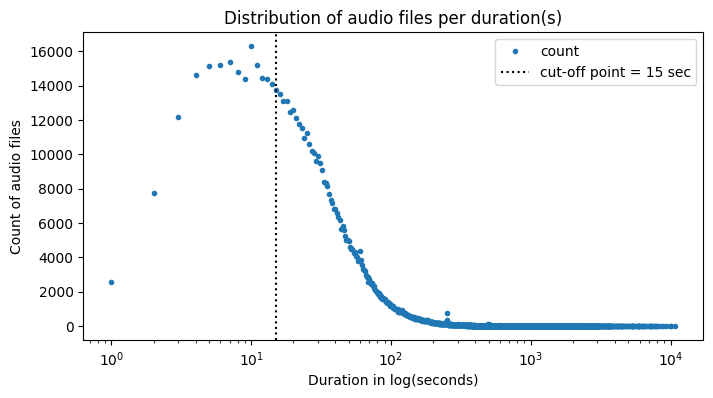

In [ ]:
## Count of audio files in mpeg and wave as function of duration in seconds
merged_df['duration_seconds'].sort_values().value_counts().plot(figsize = (8,4),linestyle='',marker='.')
plt.axvline(15,color='black',linestyle=':', label='cut-off point = 15 sec')
plt.xlabel("Duration in log(seconds)")
plt.ylabel("Count of audio files")
plt.xscale('log')
plt.title("Distribution of audio files per duration(s)")
plt.legend();

### **2.b.2.  Data Selection based on Region and Duration Filtering**

*   GBIF Region Present and == Europe
*   Sound Files only
*   files 15 sec or less

Applying these filters reduced the overall data from 700K to 80K (which roughly took 20 hours to download), which is large but more manageable than the original size.

Futher, we tried to plot count of audio samples per generic names, species, genus and vernacular names to identify if there is any opportunity to further filter the data while keeping the consistency among samples.

In [ ]:
# Identify which continent has most occurences
merged_df['continent'].value_counts().head()

continent
EUROPE           253659
SOUTH_AMERICA     96897
NORTH_AMERICA     96250
ASIA              79197
AFRICA            51018
OCEANIA           19781
ANTARCTICA          222
Name: count, dtype: int64

In [ ]:
merged_df['continent'].count()

597024

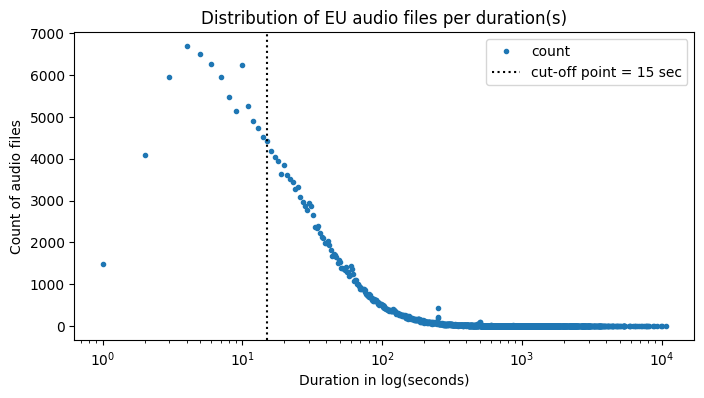

In [ ]:
## Count of audio files in mpeg and wave as function of duration in seconds
eu_df = merged_df[merged_df.continent == 'EUROPE']

eu_df['duration_seconds'].sort_values().value_counts().plot(figsize = (8,4),linestyle='',marker='.')
plt.axvline(15,color='black',linestyle=':', label='cut-off point = 15 sec')
plt.xlabel("Duration in log(seconds)")
plt.ylabel("Count of audio files")
plt.xscale('log')
plt.title("Distribution of EU audio files per duration(s)")
plt.legend();

In [ ]:
# Using the continent of most occurences and applying filter on audio duration to less than or equal to 15 seconds
proposed_df = merged_df[(merged_df['continent']=='EUROPE') & (merged_df['duration_seconds']<= 15) ]

# counts and timing
print('Counts of samples: ',len(proposed_df))
print('Seconds to download: ',len(proposed_df)*1)
print(f'Hours to download: {len(proposed_df)/(60*60):.2f}')

Counts of samples:  77679
Seconds to download:  77679
Hours to download: 21.58


#### **2.b.3. Exploration of Prediction Level, Species, Genus, Vernacular Name**

In [ ]:
# outcome of interest
print('Unique generic names: ',len(proposed_df.genericName.unique()))
print('Unique vernacular name: ',len(proposed_df.vernacularName.unique()))
print('Unique species: ',len(proposed_df.species.unique()))
print('Unique genus: ',len(proposed_df.genus.unique()))

Unique generic names:  279
Unique vernacular name:  580
Unique species:  575
Unique genus:  274


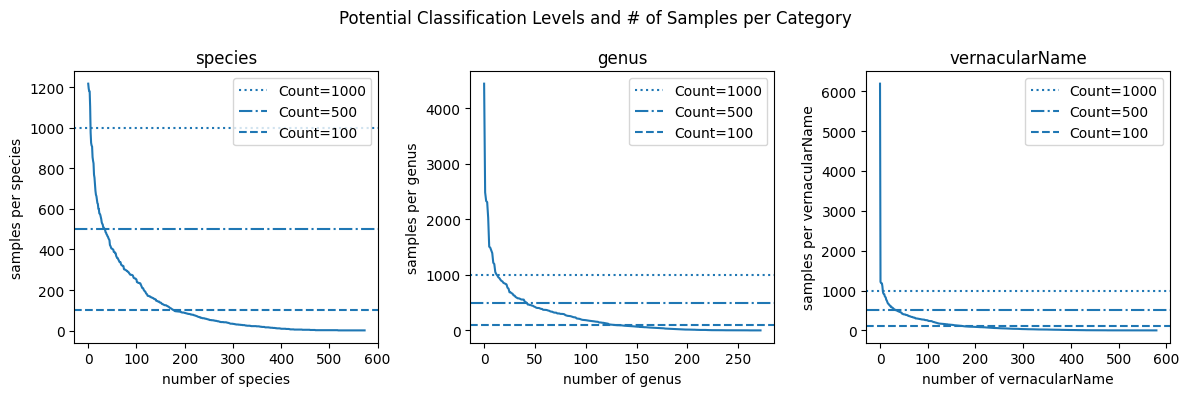

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))
ax = axes.flatten()

cols =['species','genus','vernacularName']

for i,j in enumerate(cols):
  range = np.arange(0,len(proposed_df[j].value_counts()),1)
  counts = proposed_df.species.value_counts()

  ax[i].set_title(j)
  ax[i].plot(range,proposed_df[j].value_counts())
  ax[i].axhline(1000,linestyle=":",label =f'Count=1000')
  ax[i].axhline(500,linestyle="-.",label =f'Count=500')
  ax[i].axhline(100,linestyle="--",label =f'Count=100')
  ax[i].set_xlabel(f'number of {j}')
  ax[i].set_ylabel(f'samples per {j}')
  ax[i].legend();

plt.suptitle('Potential Classification Levels and # of Samples per Category')
plt.tight_layout();

In [ ]:
#proposed_df.to_csv(os.path.join(base_path, "proposed_df.csv"))

## **2.c. Final Sample Selection for POC Model**

- Review different classification names (generic, vernacular, species or genus) to select our class labels for modeling.
- We noticed that Vernacular Names (common sense names) with at least 1000 audio samples, would give us 200 prediction labels (bird types).
- Limiting the number of samples per vernacular name to 1000 would reduce the number of samples we processed, but may be enough for good quality predictions (to be tested further)
- Apart from the bird species taxonomy, there is also the background birds (noise, if we want only one bird output) field and bird behavior to consider. As outlined below, additional noise can be a challenge, and whether to filter those observations out or use them will have to be weighed. Regarding the type of behavior, an overwhelming majority of data is for bird calls or songs. We may seperately classify both. Noteably, a [review](https://www.viewsfromanurbanlake.co.uk/2014/09/bird-songs-sunbird-images-app-review.html) of the Sun Bird song identification app critisizes that it does not discriminate between these two behavior types. It is therefore a valuable improvement.

#### **2.c.1.Further Data Analysis and Sample Narrowed to Top 10 Birds with Data Availability for Song and Behaviors**

In order to account for bird behaviors that may vary within the sample, we segmented out data into CALL and SONG type behaviors and determined the top 10 birds by vernacular name for each behavior type.  The SONG category was selected for our first prediction set, given it was smaller (easier to process) but also provided an additional challenge through higher class imbalance and lower samples.  The Calls behavior has more samples that surpass the 200 sample mark, so we also created a 80 bird_call samples on top of the 10 bird_song samples that could be used for future expanded predictions.

In [ ]:
proposed_df = pd.read_csv(os.path.join(base_path, "proposed_df.csv"), index_col = 0)

In [ ]:
# Generate total sample count and subtract samples without identification information
total_sample = proposed_df.gbifID.count()
count_unknown = proposed_df[proposed_df.vernacularName == 'Identity unknown'].gbifID.count()

total_excluding_unk = total_sample-count_unknown
total_sample,count_unknown,total_excluding_unk

(77679, 6189, 71490)

In [ ]:
######  Narrow Data Set to Top 10 Vernacular Names, with Songs and Calls (Use Songs) #######
#Add a concatenated column for birds and behaviors
proposed_df['bird_behavior'] = proposed_df.behavior+'_'+proposed_df.vernacularName

#Create a unique list of bird_names
bird_names = proposed_df.vernacularName.unique()

#Get rid of items where vernacular name is unknown
bird_df = proposed_df[proposed_df.vernacularName != 'Identity unknown']

##### Create dataframe of calls for top 10 birds ####
behaviors = ['call','flight call','nocturnal flight call','flight call, nocturnal flight call', 'call, flight call']
call_top10_df = bird_df[bird_df.behavior.isin(behaviors)]

#counts for calls
call_top10_cts = call_top10_df.vernacularName.value_counts()[:10]
call_top10_names = call_top10_cts.index

#Limit dataframe to top 10 birds by call
call_top10_df = call_top10_df[call_top10_df.vernacularName.isin(call_top10_names)]

##### Create dataframe of songs for top 10 birds #####
behaviors = ['song','song, subsong','subsong','song, aberrant']#
song_top10_df = bird_df[bird_df.behavior.isin(behaviors)]

#conts & names for songs
song_top10_cts = song_top10_df.vernacularName.value_counts()[:10]
song_top10_names = song_top10_cts.index

#Limit dataframe to top 10 birds by songs
song_top10_df = song_top10_df[song_top10_df.vernacularName.isin(song_top10_names)]

##### Create dataframe of calls for top 80 birds ####
behaviors = ['call','flight call','nocturnal flight call','flight call, nocturnal flight call', 'call, flight call']
call_top_df = bird_df[bird_df.behavior.isin(behaviors)]

#counts for calls
call_top_cts = call_top_df.vernacularName.value_counts()[:80]
call_top_names = call_top_cts.index

#Limit dataframe to top 80 birds by call
call_top_df = call_top_df[call_top_df.vernacularName.isin(call_top_names)]

#Create a data frame with the top 80 calls and top 10 songs
call_top_df['bird_behavior'] = [j+'_call' for j in call_top_df.vernacularName]
song_top10_df['bird_behavior'] = [j+'_song' for j in song_top10_df.vernacularName]
call_song_top_df = pd.concat([song_top10_df,call_top_df],axis = 0)

In [ ]:
#Save metadata to dfs:
#song_top10_df.to_csv(os.path.join(base_path, "wip/song_top10_df.csv"))
#call_top10_df.to_csv(os.path.join(base_path, "wip/call_top10_df.csv"))
call_song_top_df.to_csv(os.path.join(base_path, "call_song_top_df.csv"))

In [ ]:
print('Count of SONG samples for Top 10 Birds:', len(song_top10_df))
print('Names of Top 10 Bird by SONG:', song_top10_names)
print('Count of CALL samples for Top 10 Birds: ', len(call_top10_df))
print('Names of Top 10 Bird by CALL:', call_top10_names)
print('Count of CALL and SONG samples for Top 90 Birds: ', len(call_song_top_df))

Count of SONG samples for Top 10 Birds: 2901
Names of Top 10 Bird by SONG: Index(['Cetti's Warbler', 'Eurasian Wren', 'Common Cuckoo', 'Great Tit',
       'Eurasian Blackcap', 'Willow Warbler', 'Common Chiffchaff',
       'Common Quail', 'Common Chaffinch', 'European Green Woodpecker'],
      dtype='object', name='vernacularName')
Count of CALL samples for Top 10 Birds:  7773
Names of Top 10 Bird by CALL: Index(['Common Moorhen', 'Red Crossbill', 'Water Rail', 'Redwing',
       'Eurasian Coot', 'Common Sandpiper', 'Common Blackbird', 'Song Thrush',
       'Tree Pipit', 'European Robin'],
      dtype='object', name='vernacularName')
Count of CALL and SONG samples for Top 90 Birds:  33111


**Miscellany for Reporting**

In [ ]:
song_top10_df.vernacularName.value_counts()

vernacularName
Cetti's Warbler              699
Eurasian Wren                334
Common Cuckoo                307
Great Tit                    256
Eurasian Blackcap            244
Willow Warbler               236
Common Chiffchaff            227
Common Quail                 215
Common Chaffinch             209
European Green Woodpecker    174
Name: count, dtype: int64

In [ ]:
call_top10_df.vernacularName.value_counts()

vernacularName
Common Moorhen      972
Red Crossbill       965
Water Rail          959
Redwing             830
Eurasian Coot       822
Common Sandpiper    717
Common Blackbird    671
Song Thrush         654
Tree Pipit          600
European Robin      583
Name: count, dtype: int64

In [ ]:
bird_df.species.value_counts()[:5]

species
Gallinula chloropus    1218
Rallus aquaticus       1194
Turdus merula          1181
Loxia curvirostra      1180
Turdus iliacus         1104
Name: count, dtype: int64

In [ ]:
bird_df.genus.value_counts()[:5]

genus
Turdus          4438
Anthus          2482
Phylloscopus    2328
Emberiza        2308
Tringa          2025
Name: count, dtype: int64

In [ ]:
bird_df.vernacularName.value_counts()[:5]

vernacularName
Common Moorhen      1218
Water Rail          1194
Common Blackbird    1181
Red Crossbill       1180
Redwing             1104
Name: count, dtype: int64

### **2.c.2.  Final Cohort Selection**

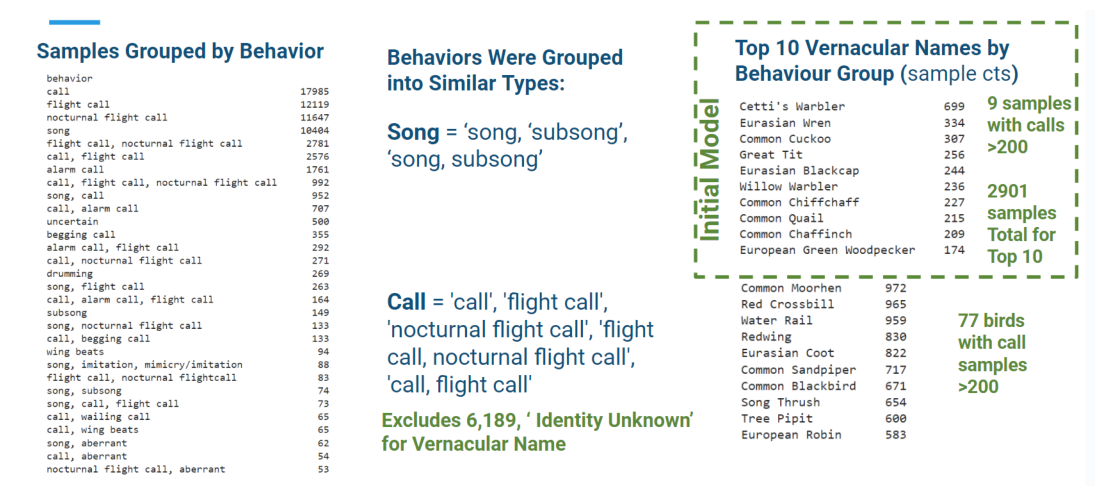

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/sample.png'))
plt.figure(figsize=(14, 10))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

# **3. Audio Processing Refinement**

The project first took individual audio files and processed them to review best practices in using TensorFlow I/O audio functionatlity.  These findings were used to generate a more robust data processing function to generate image samples for our selectected bird subset.

[Tensorflow I/O Documentation]([https://www.tensorflow.org/io/api_docs/python/tfio/audio)

### Key Findings

1.   Audio must be converted into a tensor for effective processing

2.   Each audio has its own sampling rate, which needs to be standardized across all audios. This is done through resampling.

3. Audios can come with one or two channels. All audios must therefore must be standardized into one channel by taking the mean of the two channels.

4. Some audios are quiet/far away from the bird. In order to compare audios effectively, the files must be normalized in a range of -1 to 1, where the maximum amplitude is used as basis.

5. Long tails of silence can occur both at the start and/or end of audios. This causes discrepencies in the appearance of signals; trimming is applied to keep only the parts where the bird sings.

6. Adding padding to reach the specified length of 15 seconds across all audios equally results in long tails of silence. Instead, audio looping is utilized. Padding also requires resizing (padding) of images at the time of model input, which is an extra pre-processing step that results in a sub-optimal visualization. Looping eliminates this need as all image acquire the same dimensions.

7. Final image generation: a mel spectrogram in decibels is the most aligned with the human auditory system's perception of sound and creates the clearest image compared to the other alternatives tested (spectrogram, spectrogram in decibels, mel spectrogram not in decibels).

These findings are represented in the visualizations below, where the first image shows the trimmed and normalized audio in green, and the second illustrates the effectiveness of mel spectrograms vs. spectrograms and how they compare to an audio signal that is only in the time domain (Normalized_Audio) instead of both time and frequency.

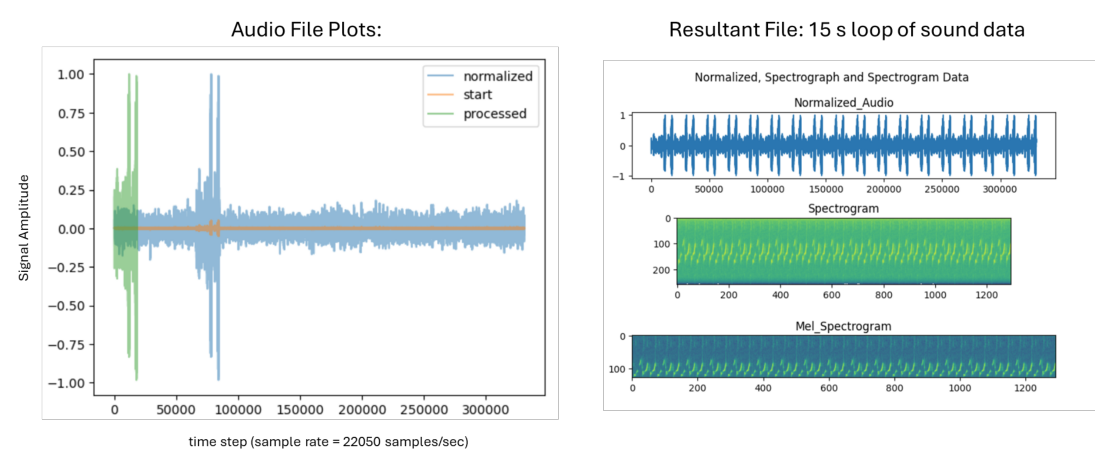

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/preprocessing.png'))
plt.figure(figsize=(14, 10))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

### **3a. Audio Processing: Single Sample Example**

In this section, the effect of audio processing is tested in order to build a pipeline. This entails loading the audio into tensors and observing the effects of different pre-processing techniques that are applied. Finally, spectrograms, mel spectrograms and mel spectrograms in decibel scale are compared to choose a final input format for the model.

https://www.tensorflow.org/io/tutorials/audio <br>
https://www.geeksforgeeks.org/audio-data-preparation-and-augmentation-in-tensorflow/

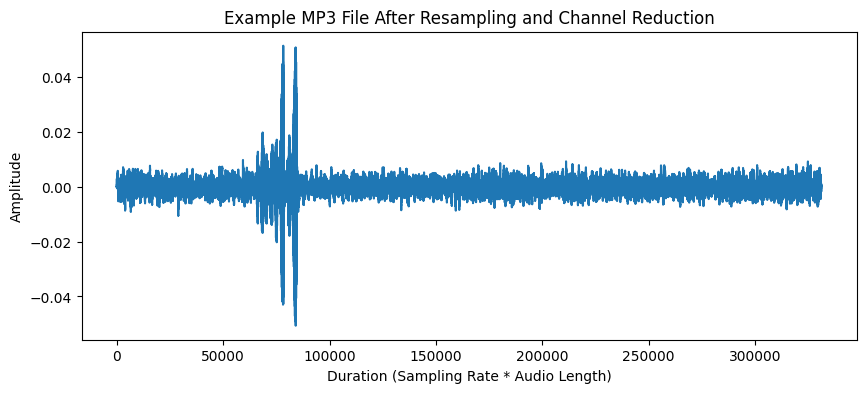

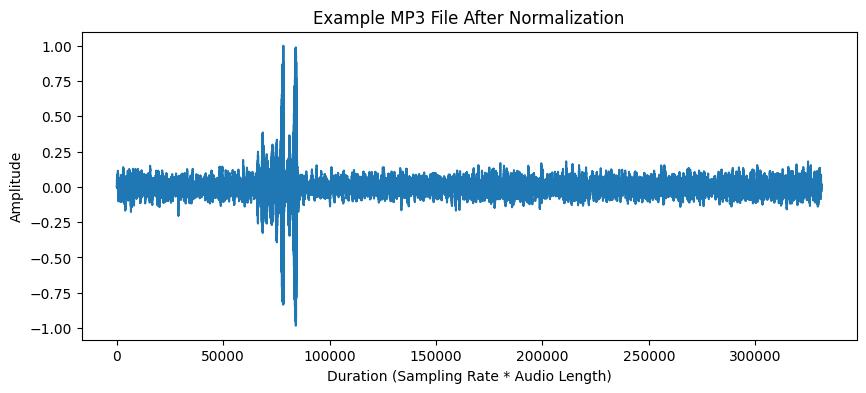

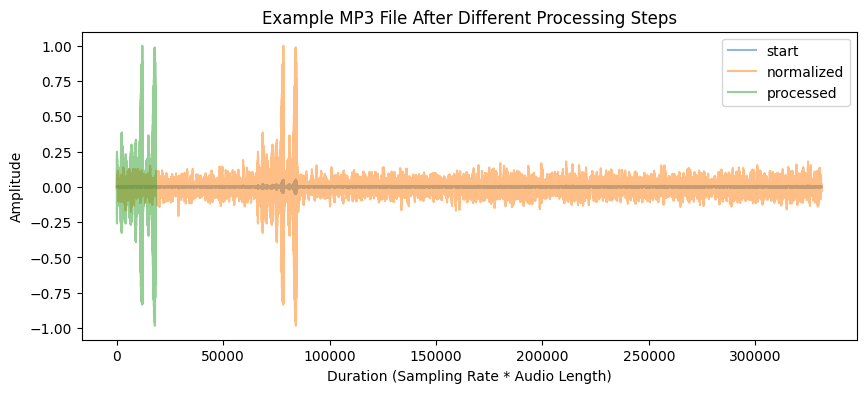

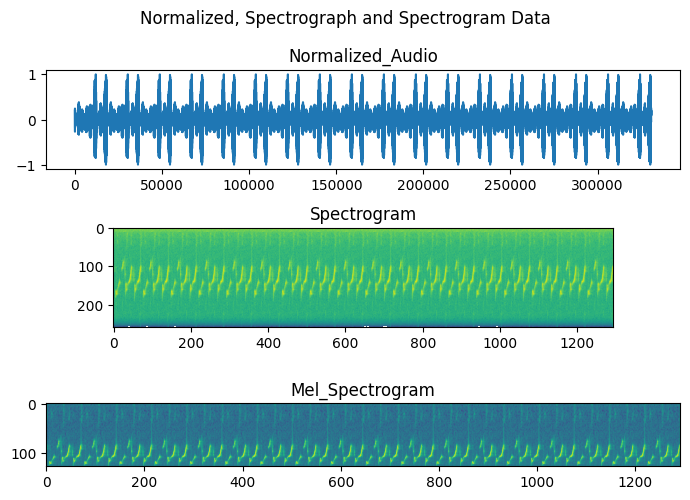

In [ ]:
# Sample file names to test
#filename = 2243609577 #2609683982
filename = 3353656819 # mp3 file
#filename = 4173213196 #wav

## General parameters
samp_rate = 22050 # hyperparameter to standardize the sampling rate across all recordings
sec_to_keep = 15 # our project scope is limited to 15 second recordings
desired_length = samp_rate * sec_to_keep # based on the samp_rate and sec_to_keep, we have a final length
epsilon = 0.2  #Filters out baseline noise
spec_nftt = 512
spec_window =512
spec_stride = 256
mel_mels = 128
mel_fmin = 1000
mel_fmax = 8000
db_scale_top_db = 70

## Load sample sound file and create tensor
audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f"mp3/{filename}.mp3")) #mp3 test
#audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f"wav/{filename}.wav"))#, dtype=float)  #wav test
audio_sampling_rate = audio.rate.numpy()
audio_tensor = audio.to_tensor()

audio_tensor=tf.cast(audio_tensor, tf.float32) #/ 32768.0 # necessary for WAV files, MP3s are already float32

audio_sampling_rate  # sampling rate specific to each audio file, necessary for conversion to a chosen sampling rate

#Handle channels: if the file is  two-channelled, convert it into one channel. Else, the file is one-channeled and must be reshaped into (audio,).
if len(audio_tensor.shape) > 1 and audio_tensor.shape[-1] == 2:
    audio_tensor = tf.reduce_mean(audio_tensor,-1)
else:
    audio_tensor = tf.squeeze(audio_tensor, axis=-1)

#Adjust sampling rate to the rate in the file
audio_tensor = tfio.audio.resample(audio_tensor, rate_in=audio_sampling_rate, rate_out=samp_rate)

plt.plot(audio_tensor)
plt.xlabel('Duration (Sampling Rate * Audio Length)')
plt.ylabel('Amplitude')
plt.title('Example MP3 File After Resampling and Channel Reduction')
plt.show()

#Normalization
normalized_audio = librosa.util.normalize(audio_tensor)

plt.plot(normalized_audio)
plt.xlabel('Duration (Sampling Rate * Audio Length)')
plt.ylabel('Amplitude')
plt.title('Example MP3 File After Normalization')
plt.show()

#Remove silence
position = tfio.audio.trim(normalized_audio, axis=0, epsilon=epsilon)
start = position[0]
stop = position[1]
processed = normalized_audio[start:stop]

plt.plot(audio_tensor, alpha = .5,label = 'start')
plt.plot(normalized_audio, alpha = .5,label = 'normalized')
plt.plot(processed, alpha = .5, label = 'processed')
plt.legend()
plt.xlabel('Duration (Sampling Rate * Audio Length)')
plt.ylabel('Amplitude')
plt.title('Example MP3 File After Different Processing Steps')
plt.show()

##15 min loop
if processed.shape[0]< desired_length:
    loops = desired_length//processed.shape[0]+1
    audio_sample_new = np.zeros((loops*processed.shape[0],1)).astype('float32')

    for l in np.arange(0,loops,1):
        audio_sample_new[len(processed)*l:(len(processed)*l+len(processed)),0] = processed

    #clip to desired length and save
    audio_sample = audio_sample_new[:desired_length]
    #write(os.path.join(base_path,f'15s/audio/{filename}.wav'), samp_rate,audio_sample[:,0])

    #Create spectrogram
    spectrogram = tfio.audio.spectrogram(audio_sample[:,0], nfft=spec_nftt, window=spec_window, stride=spec_stride)

elif audio_sample.shape[0]>= desired_length:
    audio_sample= processed[:desired_length]
    #Create spectrogram
    spectrogram = tfio.audio.spectrogram(audio_sample, nfft=spec_nftt, window=spec_window, stride=spec_stride)
    #save copy of file
    #write(os.path.join(base_path,f'15s/audio/{filename}.wav'), samp_rate,audio_sample)

### Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=samp_rate, mels=mel_mels, fmin=mel_fmin, fmax=mel_fmax)

###Filter high db sound
dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=db_scale_top_db)


####Summary Plot
fig, axes = plt.subplots(3,1, figsize=(7, 5))
ax = axes.flatten()

ax[0].plot(audio_sample)
ax[0].set_title('Normalized_Audio')

#ax[1].axis('off')
ax[1].set_title('Spectrogram')
ax[1].imshow(tf.math.log(spectrogram).numpy().T);

#ax[2].axis('off')
ax[2].set_title('Mel_Spectrogram')
ax[2].imshow(tf.math.log(mel_spectrogram).numpy().T);

plt.suptitle(f'Normalized, Spectrograph and Spectrogram Data');
plt.tight_layout()

**Audio Play at Various Stages**

In [ ]:
#Play the file
#Audio(normalized_audio, rate=samp_rate)
#Audio(audio_tensor, rate=samp_rate)
Audio(processed, rate=samp_rate)

### **3b. Audio and Image: Multiple Sample Generation**

The final audio and image sampling pipeline leverages the TensorFLow I/O audio package to normalize, reduce background noise, trim samples to isolate bird sound, and then loops them to a full 15 seconds to ensure consistent file lengths.  The sound files are then converted to mel spectrogram image files.

Prior to the pipeline, we also created an 'oversample' function that calculates the largest class and then randomly samples images and varies some of the image generation settings in order to create a balanced number of samples for each class.  The oversampling function was introduced after testing the baseline model and realizing that there was a strong majority class that may be creating class imbalance.  

While more robust transformations using the ImageDataGenerator function in our next pipeline step were also attempted, we found that those settings created noise that lowered model accuracy and found that it was more effective to perturb the mel-spectrogram generation factors, such as frequnecy and decibel filters and noise reduction factors, to generate incremental image samples. The final frequency, decibel levels, mels, noise cancellation were driven by visual inspection of images and the number of exceptions generated.  If the noise reduction was too high or if frequencies were narrowed too much, an image sample would fail to generate or and all or majority white image would be created.   Note that the image processing pipeline sometimes fails to generate a small number of the samples, however the settings were optimized to minimize these exceptions.

While this sample generation function was run numerous times to perfect sample generation, the logic remaining in this write up includes processing the 2901 original samples, and then 6990 'oversampled' images.  We also experimented with image generation on the fly, in conjunction with generating batches to feed into our model. However in our remaining approach, we directly generated images and reused those images in our subsequent steps. This way the mel-spectrograms would need to be generated only once and after they are stored in the directory that portion of the code need not be run again and resources are used more efficiently to train the model from stored images, perform several iterations as well as try different models.



In [ ]:
#Import meta data file
song_top10_df = pd.read_csv(os.path.join(base_path,"song_top10_df.csv"), index_col = 0)

### **3.b.1.Oversampling logic to increase under representated classes**

In [ ]:
def oversample(song_top10_df, max = 700):
  #what's the max sample value:
  value_counts = song_top10_df.vernacularName.value_counts()
  max_value = np.max(value_counts)

  if max_value >= max:
    max_value = max
  else:
    pass

  #Unique names to sample
  unique_names = song_top10_df.vernacularName.unique()

  #Loop through target classes and randomly sample to create equal classes
  new_ids = []
  vern_names = []
  dur = []
  audio_type = []

  for i in np.arange(0,len(unique_names),1):
    small_df = song_top10_df[song_top10_df.vernacularName == unique_names[i]].reset_index()
    for j in np.arange(0,max_value,1):
      idx = np.random.randint(0,len(small_df))
      new_ids.append(small_df.loc[idx,'gbifID'])
      vern_names.append(small_df.loc[idx,'vernacularName'])
      dur.append(small_df.loc[idx,'duration_seconds'])
      audio_type.append(small_df.loc[idx,'format'])


  #Create new df with oversampled values
  song_top10_oversample_df = pd.DataFrame({'gbifID':new_ids,'format':audio_type,'duration_seconds':dur,'vernacularName':vern_names})

  idx_ct = np.arange(0,len(song_top10_oversample_df),1)

  song_top10_oversample_df['file_name'] = [f'{x}' +'_'+ f'{y}' for x,y in zip(song_top10_oversample_df.gbifID,idx_ct)]

  return song_top10_oversample_df

#Use the function
song_top10_oversample_df = oversample(song_top10_df)

#First time we created a file to archive list:
#song_top10_oversample_df.to_csv(os.path.join(base_path,"song_top10_oversample_df.csv"), index = False)

### **3.b.2. Image / audio sampling function**  (LONG LEAD TIME 1-3 sec/sample)

In [ ]:
def bird_pipe_oversample(song_top10_oversample_df,
              audio_write = False,
              samp_rate = 22050,
              sec_to_keep = 15,
              epsilon = 0.15,
              spec_nftt = 512,
              spec_window =512,
              spec_stride = 256,
              mel_mels = 128,
              mel_fmin = 750,
              mel_fmax = 8000,
              db_scale_top_db = 70,
              aug_range = 0.1,   #Range that fmin, fmax, db_scale_top_db, epsilon will be change
              folder_name = 'wip/'):

  except_file = []
  except_df_idx = []

  desired_length = samp_rate * sec_to_keep

  #Director to save work products
  mel_spec_dir = os.path.join(base_path,f'{folder_name}')

  for i in tqdm(range(len(song_top10_oversample_df))):
  #for i in tqdm(range(300)):  #To test with 10 samples  ### Used to test a finite set of samples

      #Augment ranges of variables

      factor = np.round(np.random.uniform(-aug_range,aug_range),3)

      mel_fmin = mel_fmin * (1+factor)
      mel_fmax = mel_fmax * (1+factor)
      db_scale_top_db = db_scale_top_db * (1+factor)
      epsilon = epsilon * (1+factor)

      try:
          filename = song_top10_oversample_df.iloc[i,4]
          bird_id = song_top10_oversample_df.iloc[i,0]

          #Open file
          if song_top10_oversample_df.iloc[i,1] == 'audio/mpeg':
              audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f'mp3/{bird_id}.mp3'))
              audio_sample = audio.to_tensor()
          else:
              audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f'wav/{bird_id}.wav'))
              audio_sample = audio.to_tensor()
              audio_sample = tf.cast(audio_sample, tf.float32)

          audio_sampling_rate = audio.rate.numpy()

          #Flatten and mean balance
          if len(audio_sample.shape) > 1 and audio_sample.shape[-1] == 2:
              audio_sample = tf.reduce_mean(audio_sample,-1)
          else:
              audio_sample = tf.squeeze(audio_sample, axis=-1)

          #Adjust sampling rate to the rate in the file
          audio_sample = tfio.audio.resample(audio_sample, rate_in=audio_sampling_rate, rate_out=samp_rate)

          #Normalize (1, -1)
          audio_sample = librosa.util.normalize(audio_sample)

          #Trim portions with low baseline noise/no bird sound
          position = tfio.audio.trim(audio_sample, axis=0, epsilon=epsilon)
          start = position[0]
          stop = position[1]
          audio_sample = audio_sample[start:stop]


          #Standardize file length by repeating or truncating:
          if audio_sample.shape[0]< desired_length:
              loops = desired_length//audio_sample.shape[0]+1
              audio_sample_new = np.zeros((loops*audio_sample.shape[0],1)).astype('float32')

              for l in range(loops):
                  audio_sample_new[len(audio_sample)*l:(len(audio_sample)*l+len(audio_sample)),0] = audio_sample

              #clip to desired length and save
              audio_sample = audio_sample_new[:desired_length]

              if audio_write == True:
                write(os.path.join(base_path,f'{folder_name}/audio_{filename}.wav'), samp_rate,audio_sample[:,0])

              #Create spectrogram
              spectrogram = tfio.audio.spectrogram(audio_sample[:,0], nfft=spec_nftt, window=spec_window, stride=spec_stride)

          elif audio_sample.shape[0]>= desired_length:
              audio_sample= audio_sample[:desired_length]
              #Create spectrogram
              spectrogram = tfio.audio.spectrogram(audio_sample, nfft=spec_nftt, window=spec_window, stride=spec_stride)
              if audio_write == True:
                #save copy of file
                write(os.path.join(base_path,f'{folder_name}/audio_{filename}.wav'), samp_rate,audio_sample)

          #Create mel_spectrogram
          mel_spectrogram = tfio.audio.melscale(spectrogram, rate=samp_rate, mels=mel_mels, fmin=mel_fmin, fmax=mel_fmax)

          #Generate a plot to save
          plt.figure(figsize=(10, 4))
          plt.imshow(tf.math.log(mel_spectrogram).numpy().T)
          plt.axis('off')
          mel_spec_file = os.path.join(mel_spec_dir, f"{filename}.jpeg",)
          plt.savefig(mel_spec_file, bbox_inches='tight')
          plt.close()  # Close the plot to prevent memory leaks

          #Filter out high db sounds
          mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=db_scale_top_db)

      except:
          except_file.append(song_top10_oversample_df.iloc[i,4])
          except_df_idx.append(i)

      if i % 100 == 0:
          gc.collect() # To clear unused memory after every 100 iterations

  return except_file, except_df_idx


#### **RD 1** : Generate files with existing samples

In [ ]:
"""
song_top10_df = pd.read_csv(os.path.join(base_path,"song_top10_df.csv"))


except_file_o, except_df_idx_o = bird_pipe_oversample(song_top10_df,
              audio_write = False,  #Set if True you want to generate separate audio files in addition to pictures
              samp_rate = 22050,
              sec_to_keep = 15,
              epsilon = 0.15,
              spec_nftt = 512,
              spec_window =512,
              spec_stride = 256,
              mel_mels = 128,
              mel_fmin = 750,
              mel_fmax = 8000,
              db_scale_top_db = 70,
              aug_range = 0.01,   #Range that fmin, fmax, db_scale_top_db, epsilon will be change
              folder_name = '15s/mel_spec/')
"""

'\nsong_top10_df = pd.read_csv(os.path.join(base_path,"song_top10_df.csv"))\n\n\nexcept_file_o, except_df_idx_o = bird_pipe_oversample(song_top10_df,\n              audio_write = False,  #Set if True you want to generate separate audio files in addition to pictures\n              samp_rate = 22050,\n              sec_to_keep = 15,\n              epsilon = 0.15,\n              spec_nftt = 512,\n              spec_window =512,\n              spec_stride = 256,\n              mel_mels = 128,\n              mel_fmin = 750,\n              mel_fmax = 8000,\n              db_scale_top_db = 70,\n              aug_range = 0.01,   #Range that fmin, fmax, db_scale_top_db, epsilon will be change\n              folder_name = \'15s/mel_spec/\')\n'

#### **RD 2** : Generate files using oversampling  

In [ ]:
#Load oversampled df from memory #Round 1 file
song_top10_oversample_df = pd.read_csv(os.path.join(base_path,"song_top10_oversample_df.csv"))

In [ ]:
"""
except_file_o, except_df_idx_o = bird_pipe_oversample(song_top10_oversample_df,
              audio_write = False,  #Set if True you want to generate separate audio files in addition to pictures
              samp_rate = 22050,
              sec_to_keep = 15,
              epsilon = 0.15,
              spec_nftt = 512,
              spec_window =512,
              spec_stride = 256,
              mel_mels = 128,
              mel_fmin = 750,
              mel_fmax = 8000,
              db_scale_top_db = 70,
              aug_range = 0.01,   #Range that fmin, fmax, db_scale_top_db, epsilon will be change
              folder_name = '15s/mel_spec_over/')
"""

"\nexcept_file_o, except_df_idx_o = bird_pipe_oversample(song_top10_oversample_df,\n              audio_write = False,  #Set if True you want to generate separate audio files in addition to pictures\n              samp_rate = 22050,\n              sec_to_keep = 15,\n              epsilon = 0.15,\n              spec_nftt = 512,\n              spec_window =512,\n              spec_stride = 256,\n              mel_mels = 128,\n              mel_fmin = 750,\n              mel_fmax = 8000,\n              db_scale_top_db = 70,\n              aug_range = 0.01,   #Range that fmin, fmax, db_scale_top_db, epsilon will be change\n              folder_name = '15s/mel_spec_over/')\n"

In [ ]:
"""
#Exceptions Monitoring:
#flag in df
song_top10_oversample_df['exceptions'] = [True if i in except_file_o else False for i in song_top10_oversample_df.file_name]

#calculate lost by bird type
lost_by_type = song_top10_oversample_df[song_top10_oversample_df.exceptions == True].vernacularName.value_counts()

print(f'Records lost: {len(except_file_o)}')
display(lost_by_type)

"""

"\n#Exceptions Monitoring:\n#flag in df\nsong_top10_oversample_df['exceptions'] = [True if i in except_file_o else False for i in song_top10_oversample_df.file_name]\n\n#calculate lost by bird type\nlost_by_type = song_top10_oversample_df[song_top10_oversample_df.exceptions == True].vernacularName.value_counts()\n\nprint(f'Records lost: {len(except_file_o)}')\ndisplay(lost_by_type)\n\n"

In [ ]:
"""
#Save to .csv for future use
song_top10_oversample_df.to_csv(os.path.join(base_path,"song_top10_over_df.csv"), index = False)
"""

'\n#Save to .csv for future use\nsong_top10_oversample_df.to_csv(os.path.join(base_path,"song_top10_over_df.csv"), index = False)\n'

# **4.  Image Data Generator Functions**

The Image Data Generator function within TensorFlow is used to develop our image data pipeline. Mel-spectrogram images are split into 3 dataframes for training, validation and testing and then using flow_from_df() method to get these images in a batch size of 16. The validation set is used during model training to avoid data leakage and we preserve the test data until we have a final model ready to test. The `class_mode` in the pipeline is set to 'categorical' since it is a classification problem. We are shuffling the data for training to reduce any bias.

The Image Data Generator also gives us flexibility to perform data augmentation using various parameter for rotation, shifting, noise addition, flipping etc. At this step, images are rescaled to a range of 1/255 to normalize the images, but other generic transformations are not used.  While testing the baseline CNN model, these generic transformations showed lower accuracy scores than when the image pipeline omitted generic transformations. One hypothesis for this result is that very sophisticated information is encoded within our mel-spectrogram images and the generic preturbations destroy valuable information for the model learning process. With this insight, we instead conduct our image variance within our sample processing step, as discussed in Section 3.


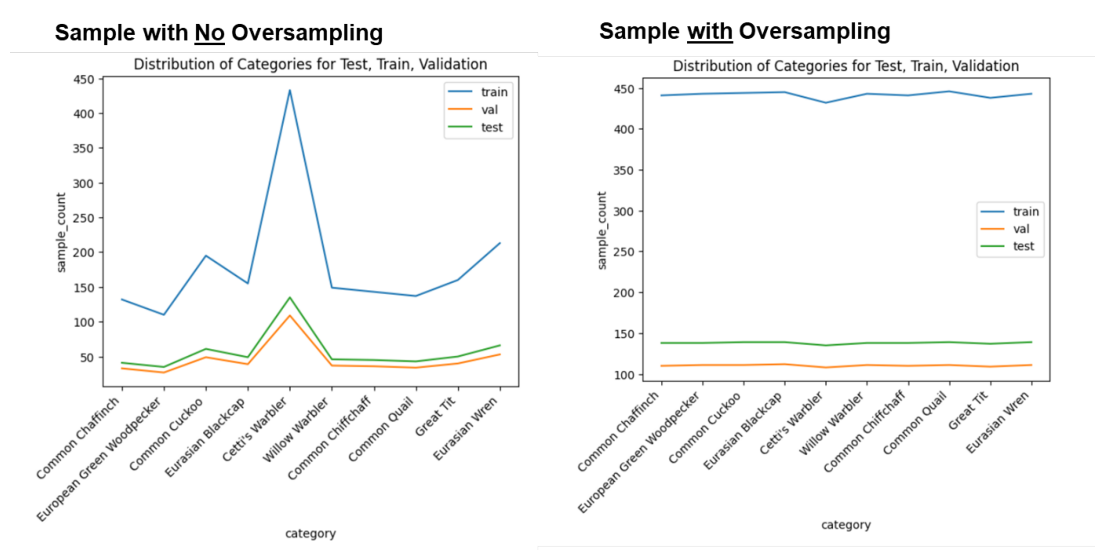

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/class_overview.png'))
plt.figure(figsize=(14, 10))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

### **4.a. Datagenerator Prep for CNN models for Train, Test, Validation**  (CAN START HERE AFTER IMPORTS)

In [ ]:
def cnn_prep_pipeline(song_top10_oversample_df,folder_name = 'wip/',image_width = 794, image_height = 96, train_batch_size = 16):
  #Add a test/train/validation/exception column to the song_top10_oversample_df:
  song_top10_oversample_split_df = song_top10_oversample_df.copy()
  cols_keep = ['gbifID','file_name','vernacularName','exceptions']
  song_top10_oversample_split_df = song_top10_oversample_split_df.loc[:,cols_keep]

  #filter the exceptions
  song_top10_oversample_split_df = song_top10_oversample_split_df[song_top10_oversample_split_df.exceptions == False]

  #test/train/split
  temp_data, test_data = train_test_split(song_top10_oversample_split_df, test_size=0.2, stratify=song_top10_oversample_split_df['vernacularName'], random_state=109)
  train_data, val_data = train_test_split(temp_data, test_size=0.2, stratify=temp_data['vernacularName'], random_state=109)

  #append Test/Train/Val to the 'Flag' Column
  song_top10_oversample_split_df['train'] = [x in train_data.file_name.values for x in song_top10_oversample_split_df.file_name]
  song_top10_oversample_split_df['test'] = [x in test_data.file_name.values for x in song_top10_oversample_split_df.file_name]
  song_top10_oversample_split_df['val'] = [x in val_data.file_name.values for x in song_top10_oversample_split_df.file_name]

  # encode labels
  name_to_index = {name: i for i, name in enumerate(song_top10_oversample_split_df['vernacularName'].unique())}
  song_top10_oversample_split_df['y'] = [str(name_to_index[x]) for x in song_top10_oversample_split_df['vernacularName']]

  ### Create translation for id's
  index_to_name = {i: name for i, name in enumerate(song_top10_oversample_split_df['vernacularName'].unique())}
  name_to_index = {name: i for i, name in enumerate(song_top10_oversample_split_df['vernacularName'].unique())}

  ###  Ensure y is the right type
  song_top10_oversample_split_df.y = song_top10_oversample_split_df.y.astype('string')

  ###Create dataframes for feeding into datag enerators
  #train
  link = [os.path.join(base_path,f'{folder_name}{i}.jpeg') for i in song_top10_oversample_split_df[song_top10_oversample_split_df.train==True].file_name]
  y_str = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.train==True].y]  #needs to be a categorical value
  traingen_df = pd.DataFrame({'x':link,'y':y_str})

  #val
  link = [os.path.join(base_path,f"{folder_name}{i}.jpeg") for i in song_top10_oversample_split_df[song_top10_oversample_split_df.val==True].file_name]
  y_str = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.val==True].y]  #needs to be a categorical value
  valgen_df = pd.DataFrame({'x':link,'y':y_str})

  #test
  link = [os.path.join(base_path,f"{folder_name}{i}.jpeg") for i in song_top10_oversample_split_df[song_top10_oversample_split_df.test==True].file_name]
  y_str = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.test==True].y]  #needs to be a categorical value
  testgen_df = pd.DataFrame({'x':link,'y':y_str})

  ### Plot of value counts for each
  plt.plot(list(name_to_index.keys()),traingen_df.y.value_counts().sort_index(),label = 'train')
  plt.plot(list(name_to_index.keys()),valgen_df.y.value_counts().sort_index(),label = 'val')
  plt.plot(list(name_to_index.keys()),testgen_df.y.value_counts().sort_index(),label = 'test')
  plt.xlabel('category')
  plt.ylabel('sample_count')
  plt.legend()
  plt.xticks(rotation=45, ha='right')
  plt.title('Distribution of Categories for Test, Train, Validation');

  ######  Image Generators for Test/Train/Validation #####
  tf.random.set_seed(109)
  np.random.seed(109)

  # Generator for train and validation data
  image_generator = ImageDataGenerator(
      rescale=1./255)

  # Train data
  train_data = image_generator.flow_from_dataframe(
      dataframe=traingen_df,
      x_col='x',
      y_col='y',
      batch_size=train_batch_size,
      seed = tf.random.set_seed(109),
      shuffle=True,
      class_mode="categorical",
      target_size=(image_width,image_height),
      color_mode="rgb")

  # val data
  val_data = image_generator.flow_from_dataframe(
      dataframe=valgen_df,
      x_col='x',
      y_col='y',
      batch_size=train_batch_size,
      seed = tf.random.set_seed(109),
      shuffle=False,
      class_mode="categorical",
      target_size=(image_width,image_height),
      color_mode="rgb")

  # test data
  test_data = image_generator.flow_from_dataframe(
      dataframe=testgen_df,
      x_col='x',
      y_col='y',
      batch_size=train_batch_size,
      seed = tf.random.set_seed(109),
      shuffle=False,
      class_mode="categorical",
      target_size=(image_width,image_height),
      color_mode="rgb")

  return train_data, test_data, val_data, valgen_df, testgen_df, name_to_index


In [ ]:
  ### Create translation for id's
  song_top10_oversample_df = pd.read_csv(os.path.join(base_path,"song_top10_oversample_df.csv"))  #Dataframe of data sample info

  index_to_name = {i: name for i, name in enumerate(song_top10_oversample_df['vernacularName'].unique())}
  name_to_index = {name: i for i, name in enumerate(song_top10_oversample_df['vernacularName'].unique())}

  name_to_index

{'Common Chaffinch': 0,
 'European Green Woodpecker': 1,
 'Common Cuckoo': 2,
 'Eurasian Blackcap': 3,
 "Cetti's Warbler": 4,
 'Willow Warbler': 5,
 'Common Chiffchaff': 6,
 'Common Quail': 7,
 'Great Tit': 8,
 'Eurasian Wren': 9}

### **4.b. No Oversampling**

Found 1827 validated image filenames belonging to 10 classes.
Found 457 validated image filenames belonging to 10 classes.
Found 571 validated image filenames belonging to 10 classes.


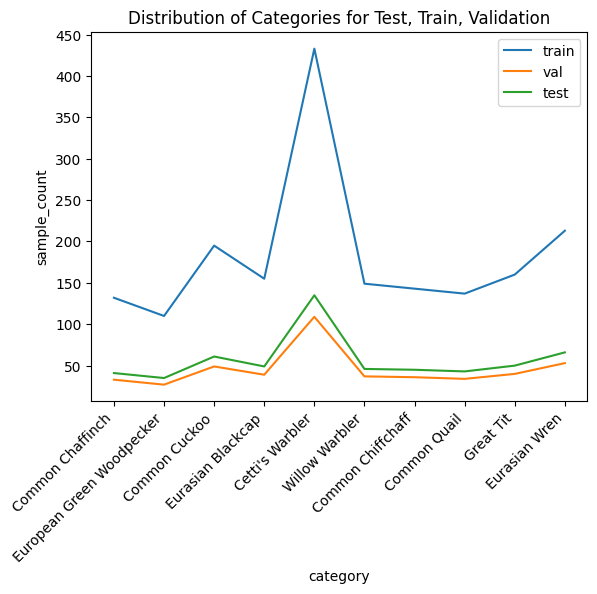

In [ ]:
###  Image Data Generator for No Oversampling
song_top10_oversample_df = pd.read_csv(os.path.join(base_path,"song_top10_df_no_oversample.csv"))  #Dataframe of data sample info
folder_name = '15s/mel_spec/'
image_width = 128
image_height = 128
train_batch_size = 16

train_data_1, test_data_1, val_data_1,valgen_df_1,testgen_df_1,name_to_index_1 = cnn_prep_pipeline(song_top10_oversample_df,folder_name = folder_name,image_width = image_width, image_height = image_height, train_batch_size = train_batch_size)

### **4.c. Oversampling - To be used with Baseline Models as well as Optimized Models**

Found 4416 validated image filenames belonging to 10 classes.
Found 1104 validated image filenames belonging to 10 classes.
Found 1380 validated image filenames belonging to 10 classes.


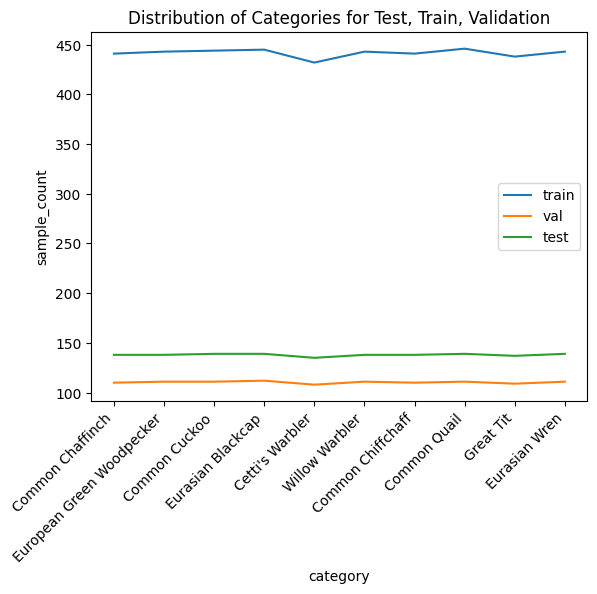

In [ ]:
###  Image Data Generator for Oversampled Data
song_top10_oversample_df = pd.read_csv(os.path.join(base_path,"song_top10_over_df.csv"))  #Dataframe of data sample info
folder_name = '15s/mel_spec_over/'
image_width = 128
image_height = 128
train_batch_size = 16

train_data_2, test_data_2, val_data_2,valgen_df_2,testgen_df_2, name_to_index_2  = cnn_prep_pipeline(song_top10_oversample_df,folder_name = folder_name,image_width = image_width, image_height = image_height, train_batch_size = train_batch_size)


# **5. Model Selection and Testing**

In this section we design and test several neural network architectures on the imbalanced as well as balanced (oversampled) dataset. We will use the data pipeline which we created in the previous section using the cnn_prep_pipeline() function. Since our data is now in the form of images,  we will mainly use a Convolution Neural Network (CNN) and experiment with the architecture based on the observations, i.e. train and validation accuracies, loss and F1-score for all the ten classes of birds. For this prupose, we have created two helper funtions as shown below:

plot_hist()
- This funtion plots the training and validation accuracies and losses as a function of epochs.

model_eval()
- This function takes several arguments including the model, training and validation data pipeline, number of epocs to run, and name of the model, etc.
- It defines two callback fuctions. First one for early stopping with patience of 5. This is done to preserve energy and unnecessary running of epochs in case if model's performance is not improved for several epochs (5 in this case).
- Second callback function is model check point to save the best weights achieved during the training process.
- Model fitting is performed in model_eval()
- At the end of training, model evalation is performed training and validation data using the best weights.
- Lastly, this function calculates the F1-score for each of the top 10 birds and plots them on a horizontal bar graph.


#### **Helper Functions**

In [ ]:
# Plot Model History
def plot_hist(model, title=None):
    fig, axs = plt.subplots(3,1, figsize=(12,14))
    epoch_range = np.arange(1,len(model.history.history['loss'])+1,1)
    axs[0].plot(epoch_range,model.history.history['loss'], label='train')
    axs[0].plot(epoch_range,model.history.history['val_loss'], label='val')
    axs[0].axvline(np.argmin(model.history.history['val_loss'])+1, c='k', ls=':', label='final model')
    axs[0].set_title('Loss by Epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('CCE Loss')
    axs[0].legend()
    axs[1].plot(epoch_range,model.history.history['accuracy'], label='train')
    axs[1].plot(epoch_range,model.history.history['val_accuracy'], label='val')
    axs[1].axvline(np.argmin(model.history.history['val_loss'])+1, c='k', ls=':', label='final model')
    axs[1].legend();
    axs[1].set_title('Val Accuracy by Epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('ACC')
    plt.suptitle(title)

    return axs

In [ ]:
def model_eval(model, train_data,val_data,valgen_df,name_to_index,epochs=10,title='Model'):

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  mc = tf.keras.callbacks.ModelCheckpoint(filepath=f'models/{title}.hi5',
                                      save_weights_only=True,
                                      save_best_only=False,
                                      monitor='val_loss')

  model.fit(train_data,
            steps_per_epoch=train_data.samples//train_data.batch_size,
            epochs=epochs,
            validation_data=val_data,
            validation_steps=val_data.samples//val_data.batch_size,
            callbacks=[es, mc])

  ##### Plot Training Histroy

  axs = plot_hist(model, f'{title}: Accuracy and Loss Plots')

  val_overall = model.evaluate(val_data)
  train_overall = model.evaluate(train_data)

  print(f'val_overall:{val_overall},train_overall: {train_overall}')

  # Save Model for future reference
  model.save(os.path.join(base_path,f'./models/{title}_model'))

  #####  Generate Predictions

  #val_data.reset()
  valpredict = model.predict(val_data,steps = np.ceil(val_data.samples/val_data.batch_size))

  predicted_class=np.argmax(valpredict,axis=1)

  labels = (val_data.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in predicted_class]

  #####  Create a dataframe tracking results by file/sample
  filenames=val_data.filenames
  results=pd.DataFrame({"Filename":filenames,
                        "Fileshort":[f[-10:] for f in filenames],
                        "Predictions":predictions})

  results['Actual']= [list(valgen_df[valgen_df.x == i].y.values)[0] for i in results.Filename]
  results['Labels'] = val_data.labels

  #####  Calculate F1 Score:

  f1 = []
  count = []

  labels_list = list(labels.values())

  for i in np.arange(0,len(labels_list),1):
      val = results.Actual[results.Actual == labels_list[i]].dropna()
      pred = results.Predictions[results.Actual == labels_list[i]].dropna()
      helper = f1_score(val, pred, average = 'weighted')
      helper2 = len(val)
      f1.append(helper)
      count.append(helper2)

  overall = f1_score(results.Actual, results.Predictions, average='weighted')

  tags = [(t + f'; n={c}') for t,c in zip(list(name_to_index.keys()), count)]

  #####  Plot F1 Score:
  axs[2].barh(tags, f1)
  axs[2].axvline(overall, label = 'Overall F-1 Performance', color = 'black', linestyle = ':')
  axs[2].set_xlabel('f1-score')
  axs[2].set_ylabel('Bird')
  axs[2].set_title(f'{title} Results: F1-Score by Bird Type: {round(overall,2)}')
  axs[2].legend(bbox_to_anchor=[1,1]);
  plt.tight_layout();

  return

### **5.a. Baseline Model with No Oversampling**

The first model we designed is our naive baseline CNN model with a basic design of 3 convolution layers with 64, 128 and 32 filters respectively. Our input dimension will remain consistent at 128 x 128 x 3 throughout the testing. Since our images are  mel spectrograms of bird songs, where the audio features are concentrated only in certain areas of the image, we started with a small kernel size of 3 to extract the small and localized features from the image. To preserve symmetry and information in the convolution step, we used padding = 'same' to ensure consitent dimensioning at the step of convolution and the size reduction is performed after each convolutional layer using maximum pooling of size 2, i.e. reducing the dimensions by half. After flattening the output from the convolution section of the model, we pass it through only one dense layer of 256 units. The last output layer has 10 units based on 10 classes in the data sample, for which we applied softmax as activation function. The output layer will also remain consistent throughout our testing.

We have choosen 30 epochs as default which will be used for all the models we will test. But with that we are using early stopping as well to ensure that the model doesn't keep running unnecessarily.

In the first step we ran the baseline model on original imbalanced data. The basline model stopped training within the first ten epochs. We saw the training and validation losses diverging very quickly after the first few epochs. The model gave us training accuracy of around 80% and validation accuracy of around 66%, suggesting severe overfitting. The average F1-score was around 65% with some birds having low F1-scores due to imbalanced data. Please note that these numbers may change upon next execution of the code due to randomness in tensorflow.

In the next step we will train the same baseline model on balanced (oversampled) data to compare the performance difference just by data augmentation.

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 32)        368

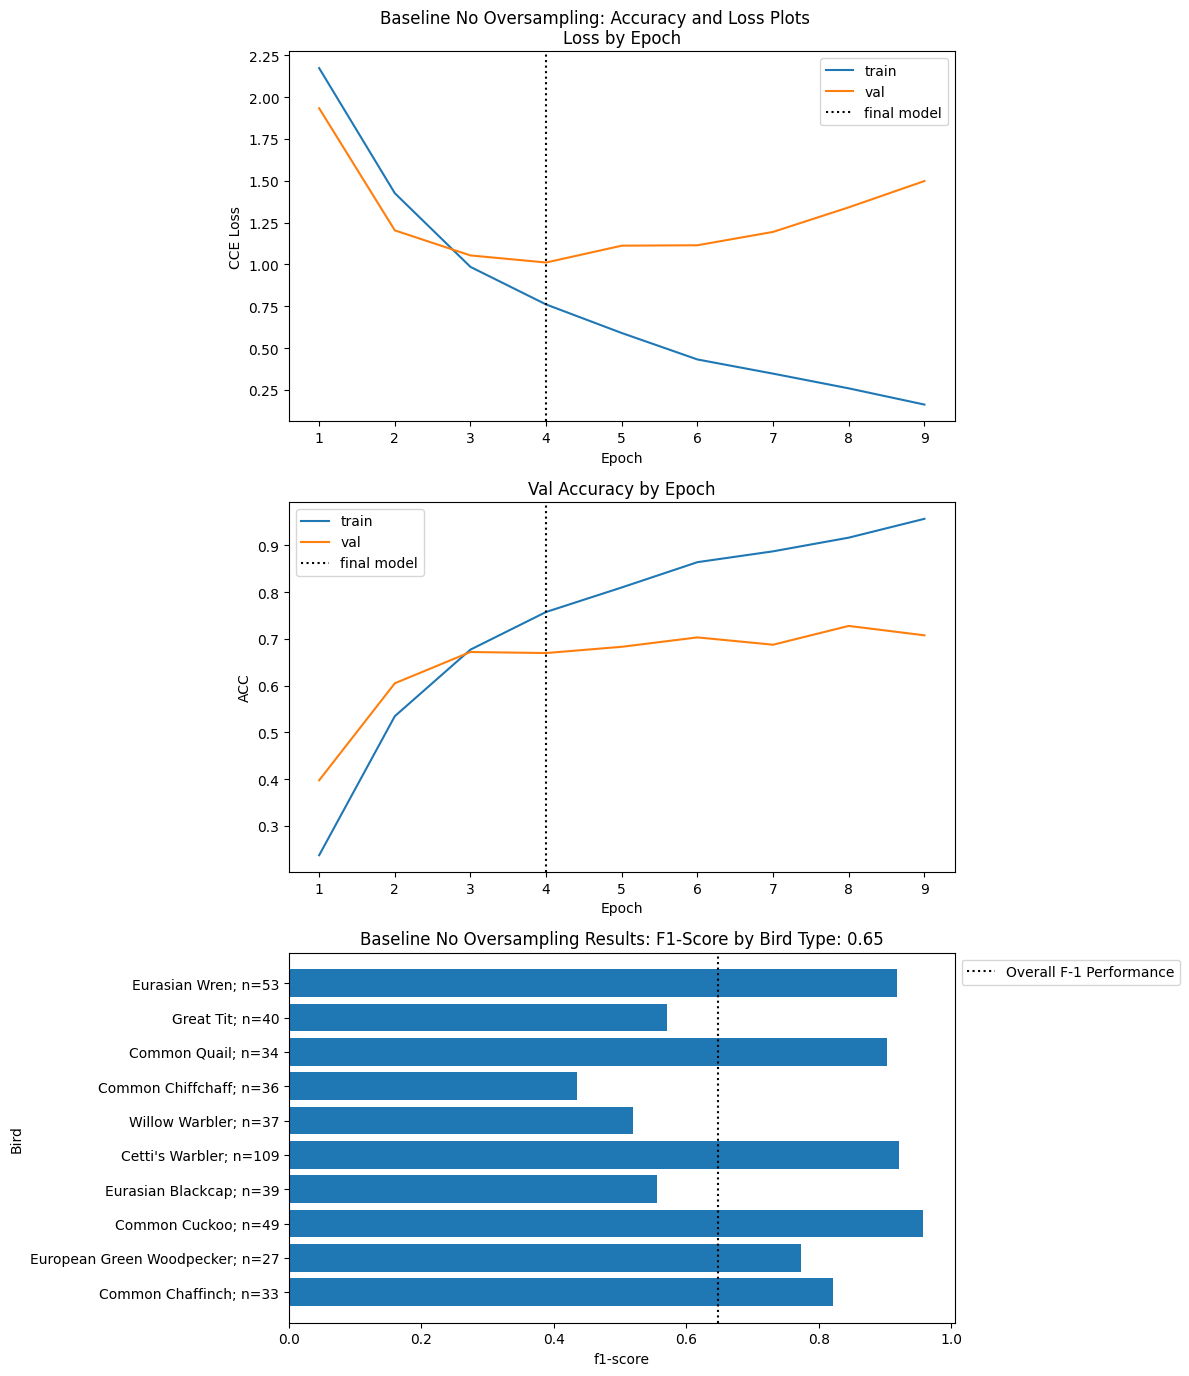

In [ ]:
def baseline_model(input_dim):

  # Baseline Model Code
  n_classes = 10
  inputs = Input(shape=(input_dim))

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)

  outputs = Dense(n_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.summary()

  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

input_dim = [128,128,3]
model = baseline_model(input_dim)
model_eval(model,train_data_1, val_data_1, valgen_df_1, name_to_index_1, 30, 'Baseline No Oversampling')

### **5.b. Baseline Model with Oversampled Data**

Upon training the same baseline model on oversampled balanced data, we saw that the model trained for more epochs and gave a boost to train and validation accuracies. We got a training accuracy of around 98% with a validation accuracy of around 91%. We still see a lot of overfitting in the results. The F1-score jumped up to low 90% with only one bird falling behind the average. The results were quite encouraging and suggested to experiment with model architectures and see if different design choices can help us improve further on accuracy, F1-score and overfitting.

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 32)        368

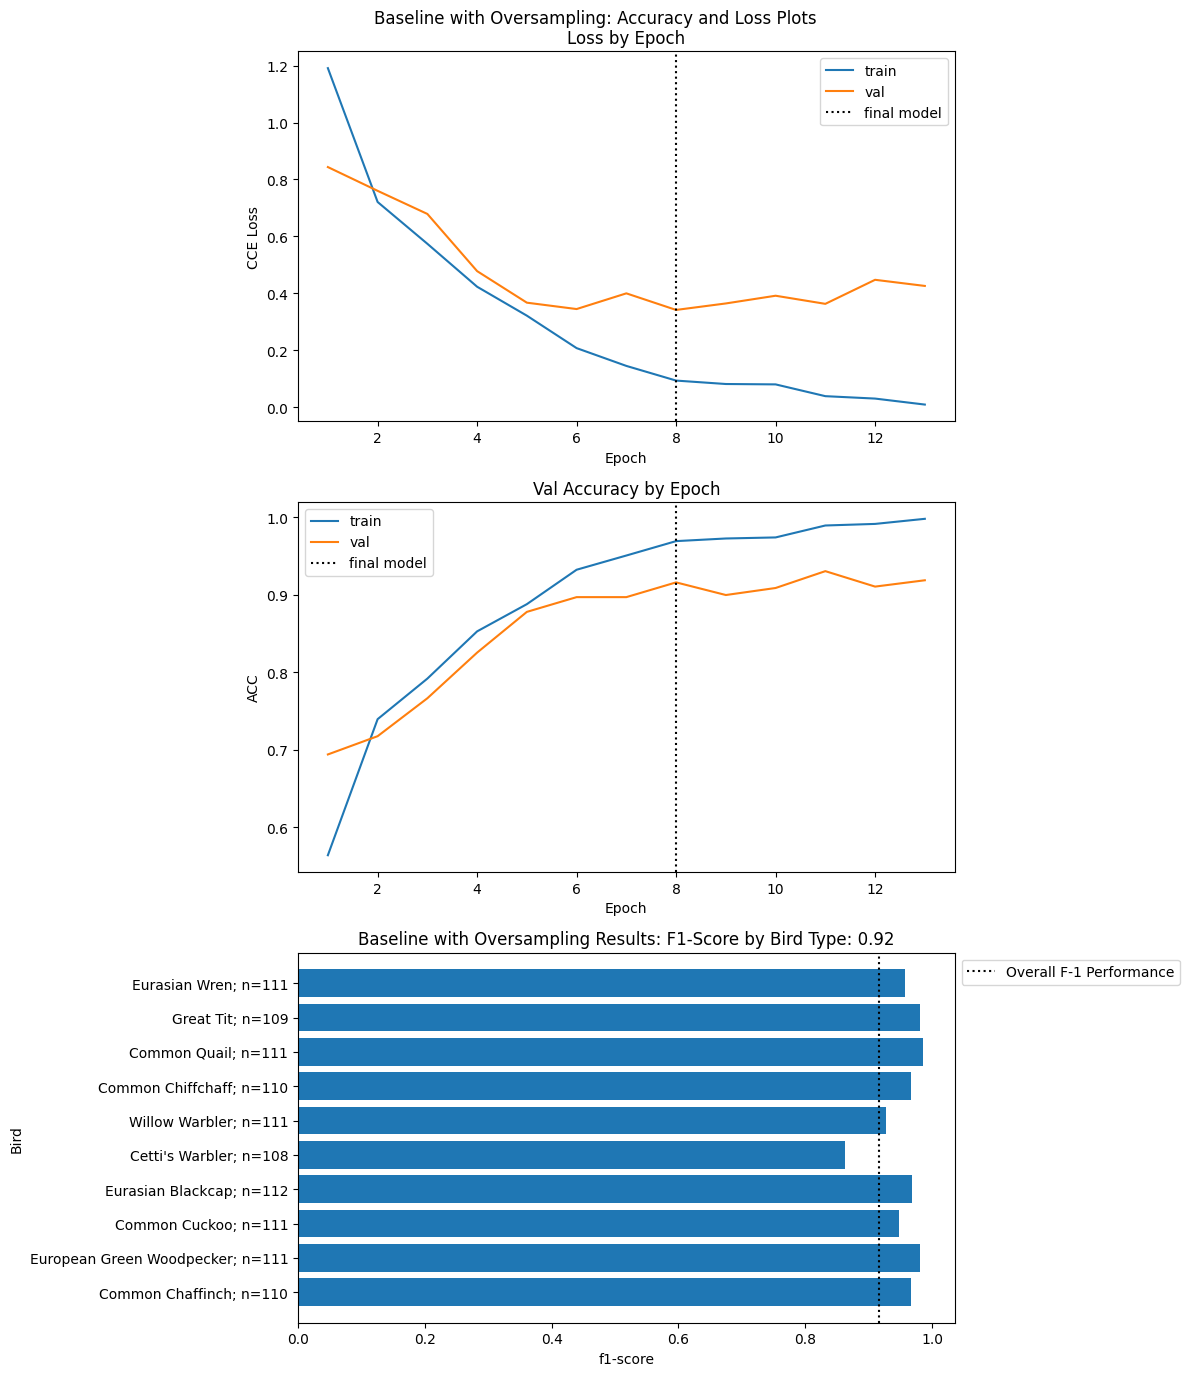

In [ ]:
input_dim = [128,128,3]
model_oversample = baseline_model(input_dim)
model_eval(model_oversample,train_data_2, val_data_2, valgen_df_2, name_to_index_2, 30,'Baseline with Oversampling')

### **5.c. Optimized Model 1 with Oversampling**

From this point onwards, all of our model training will be performed only on balanced data.

In the next iteration, we only added one more layer in the convolution network, having filters as 64, 128, 64, 32, to make the network more robust and extract more features. We also addethe d one more dense layer of 128 units on top of the previous layer of 256 units. We noticed that this network significantly reduced the total number of trainable parametrs compared to the baseline model; baseline model parameters were around 2.2 millions vs optimized model 1 of roughly 720K, which is one third of the baseline model's parameters. Upon examining the model summary, we notced that reduction in total parameters is due to size reduction after adding one more convolutional and max pooling layer which in turn reduces the number of parameters going into the dense layer.

This was an interesting observation as we found similar performance as the baseline model but at a significantly less number of trainable parameters. Therefore we decide to use the same architecture for all further enhancements in next steps.

We got a train accuracy around 97% and validation accuracy around 91%, making it slightly less overfitting than the baseline model. The average F1-score stayed above 90%, close to the F1-score from the baseline model, this time a different bird falling behind the average, suggesting this could be due to randomness in the training process. In the next steps, we will apply various regularization techniques to reduce the gap between training and validation accuracies.

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_51 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 64)        737

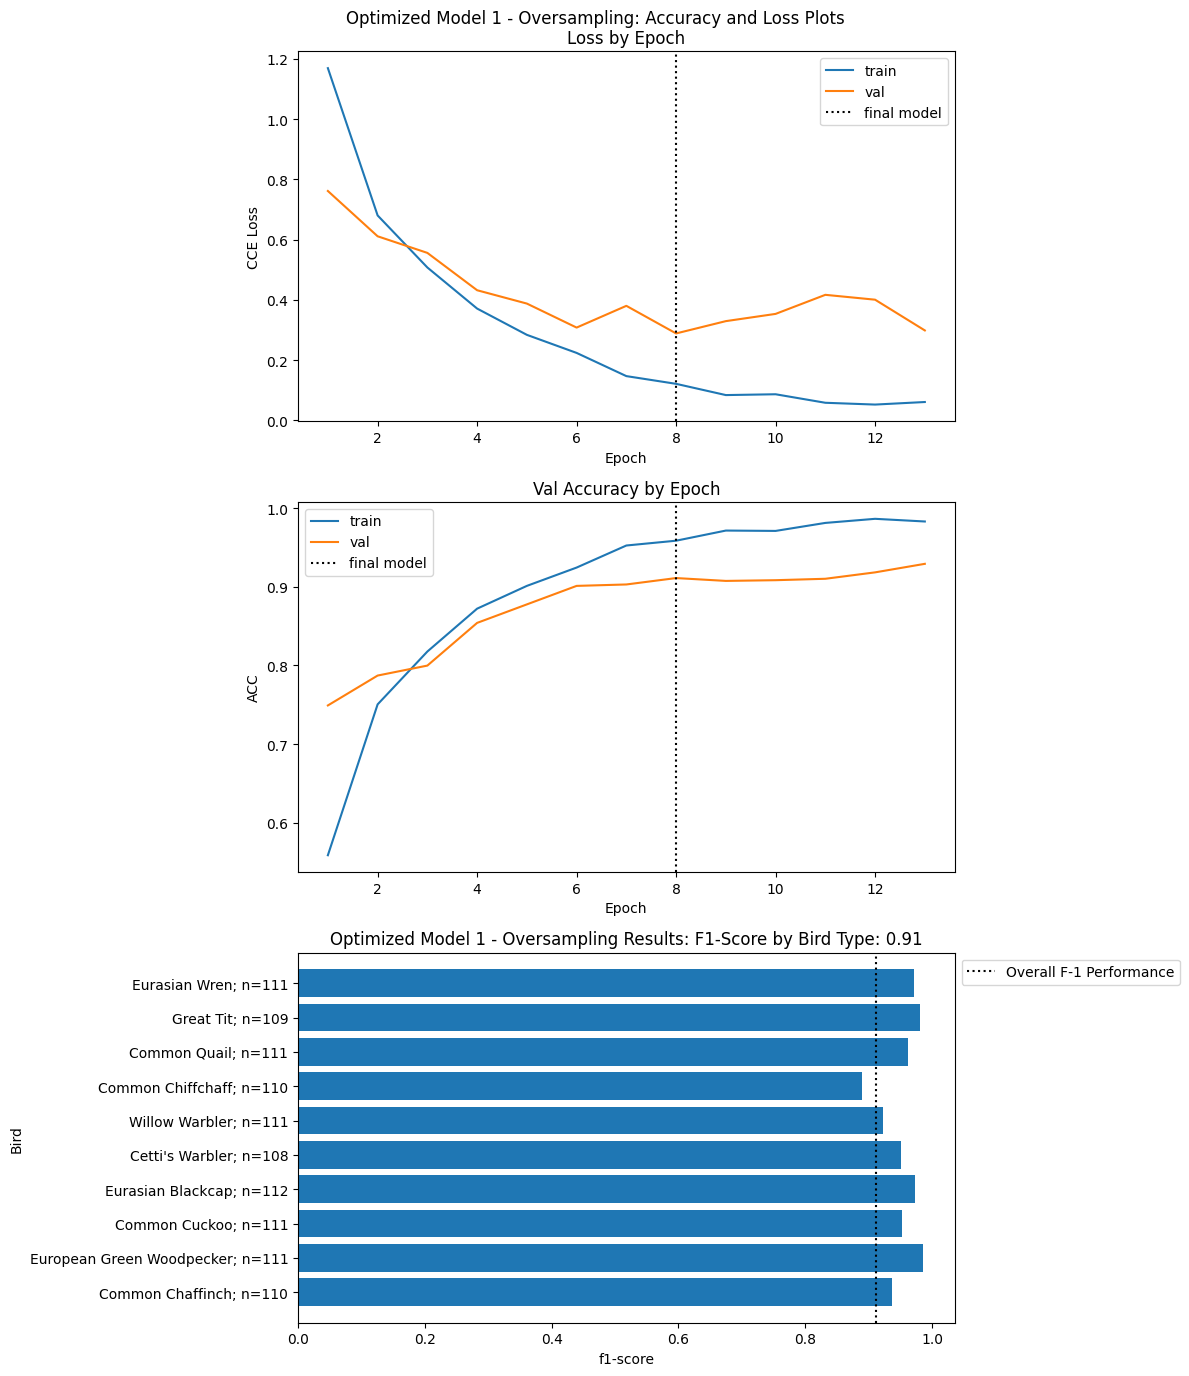

In [ ]:
def optimized_model1(input_dim):

  # Optimized Model 1 Code
  n_classes = 10
  inputs = Input(shape=(input_dim))

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)

  outputs = Dense(n_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

input_dim = [128,128,3]
optmodel_oversample = optimized_model1(input_dim)
model_eval(optmodel_oversample,train_data_2, val_data_2, valgen_df_2,name_to_index_2, 30,'Optimized Model 1 - Oversampling')

### **5.d. Optimized Model 2 - Oversampling & Regularization**

In this step we experimented with two enhancements in our design:

1. We increased the kernel size in the first 2 layers, inspired by the AlexNet architecture, hoping this would enhance high level feature extraction from the mel spectrogram.
2. Regularization: We used L1 regularization (0.0001) and dropouts (0.5) in the dense layers. We tried various values for both but these values performed best.

The number of parameters slightly increased to about 878K due to increase in kernel size, but it is still significantly lower than the baseline model. This model took more number of epochs to train compared to previous models and gave us training accuracy of around 98% but the validation accuracy increased to around 93-94% which is the highest we have achieved so far. The average F1-score also increased to mid 90%, with all the birds above 90% individually.

These are the best results we have seen so far in our modeling journey. There is still some overfitting but it is less than what we have seen in previous steps. To overcome this further, we tried to increase the regularization parameter value from 0.0001 to 0.0005 and 0.001, as well as batch normalization but neither of these gave us any additional gains.

In the next step we tried to incorporate Autoencoders as our last attempt to reduce overfitting.

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      6400      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 128)       221312    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        7379

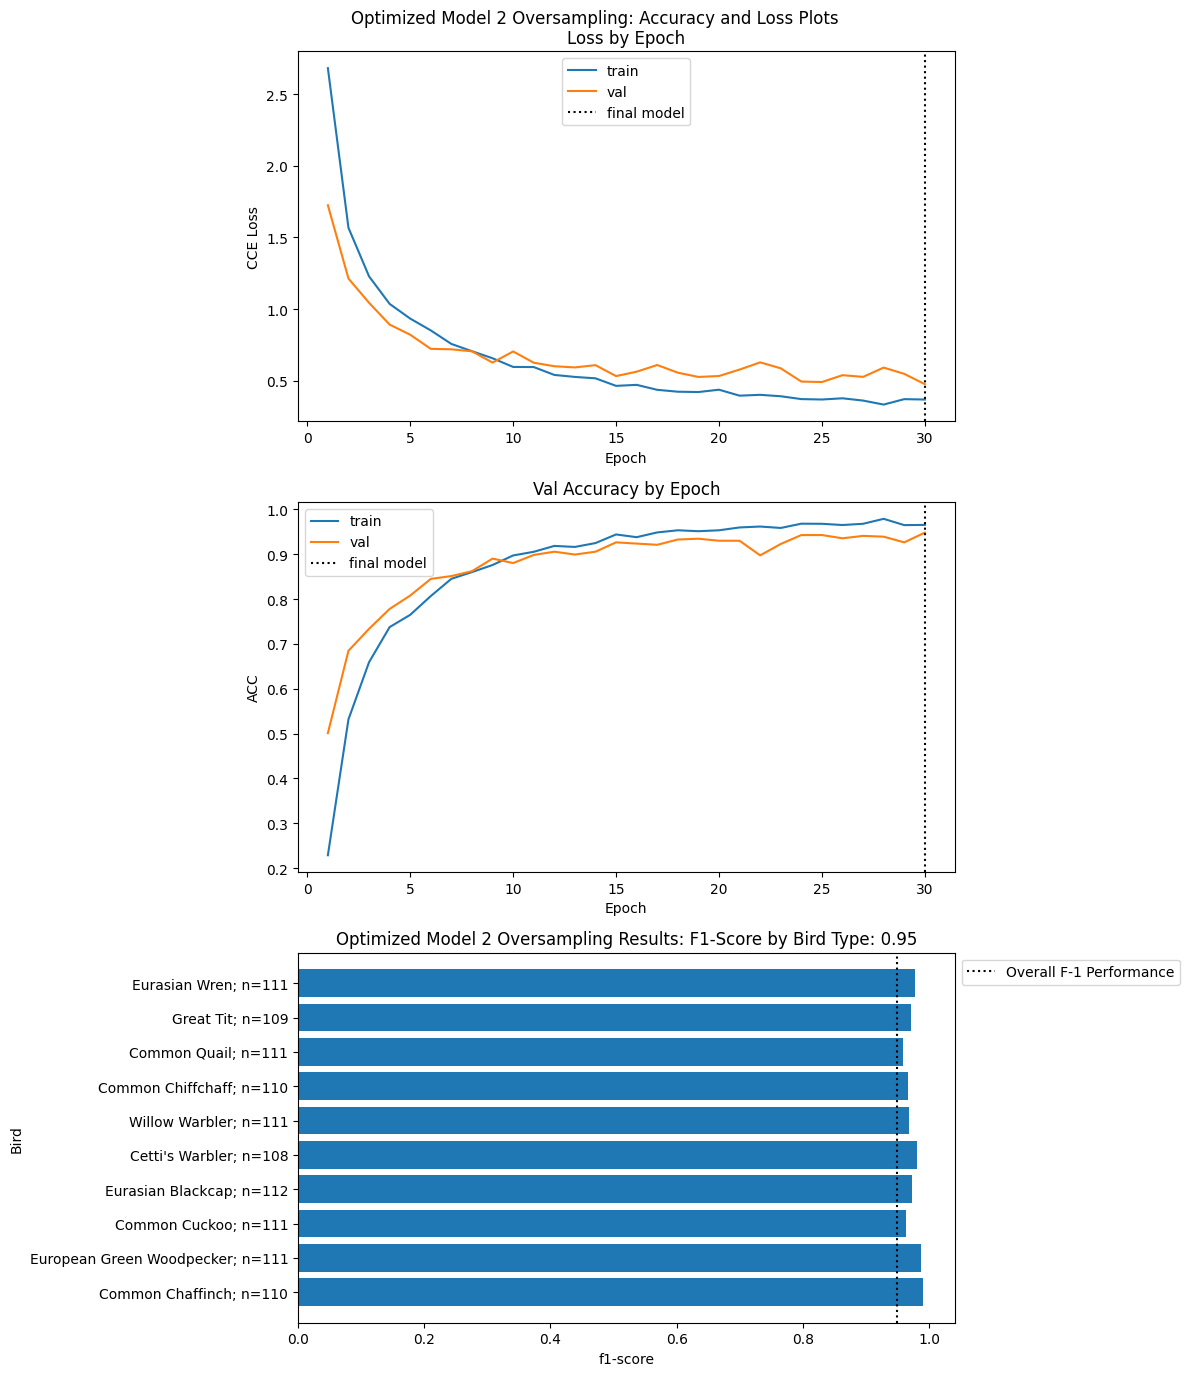

In [ ]:
def optimized_model2(input_dim):

  # Regularize Model Code
  n_classes = 10
  regularizer = 0.0001
  kernel_regularizer = L1(l1=regularizer)
  bias_regularizer = L1(l1=regularizer)
  inputs = Input(shape=(input_dim))

  x = Conv2D(64, (11, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(128, (9, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)


  x = Flatten()(x)
  x = Dense(256, activation= 'relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
  x = Dropout(0.5)(x)
  x = Dense(128, activation= 'relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
  x = Dropout(0.5)(x)


  outputs = Dense(n_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

input_dim = [128,128,3]
regmodel_regoversample = optimized_model2(input_dim)
model_eval(regmodel_regoversample,train_data_2, val_data_2, valgen_df_2,name_to_index_2, 30,'Optimized Model 2 Oversampling')

### **5.e. Optimized Model 3 - Oversampling & Regularization & Autoencoders**

In this section, we tries to add autoencoders with our optimized model 2 from the previous step as an attempt to reduce overfitting. This is going to be a two-step process, with first step to train the autoencoders. For this purpose, we extracted the images portion from our train and validation pipeline and combined them both into one dataset to train the autoencoders.

Due to time limitation, we did not experiment too much with the architecture and adopted the design as shown in the Lab on CNN. After training the autoencoders, we tested their result on the mel spectrograms and found them to make our mel spectrograms more smooth and denoised as expected (this test was done separately and not included in this notebook).

Once we finisned training the autoencoders, we froze its layers and added a layer of these autoencoders in our optimized model 2. The total number of parameters increased by approximately 121K coming from autoencoders, making the total parameters to be about 1 million. This model took longest to train out of all the models so far and gave us similar results as previous models; training accuracy of about 98% and validation accuracy of about 92%. The F1-score dropped back to low 90%.

Overall, We did not see any gain by utilizing autoencoders to help in reducing overfitting.

So far we have seen that our optimized model 2 has outperformed all of our other attempts. It gave us the highest validation accuracy with relatively lower number of trainable parameters. Therefore it will be our choice as a final model to be applied on unseen test data.

In [ ]:
# Extracting images from train and validation pipeline to train Autoencoder
num_train = len(train_data_2)
num_val = len(val_data_2)
batch_size = 32
num_images_train = num_train * batch_size
num_images_val = num_val * batch_size
all_images_train = np.zeros((num_images_train,) + train_data_2[0][0].shape[1:])
all_images_val = np.zeros((num_images_val,) + val_data_2[0][0].shape[1:])
delta_batch_train = 0
delta_batch_val = 0

# Training data
for i in range(num_train):
    batch_images = train_data_2[i][0]
    start_index = i * batch_size
    if len(batch_images) < batch_size:
        delta_batch_train = batch_size - len(batch_images)
        end_index = start_index + delta_batch_train
    else:
        end_index = start_index + batch_size
    all_images_train[start_index:end_index] = batch_images
if delta_batch_train > 0:
    all_images_train = all_images_train[:-delta_batch_train]


## Validation data
delta_batch = 0
for i in range(num_val):
    batch_images = val_data_2[i][0]
    start_index = i * batch_size
    if len(batch_images) < batch_size:
        delta_batch_val = batch_size - len(batch_images)
        end_index = start_index + delta_batch_val
    else:
        end_index = start_index + batch_size
    all_images_val[start_index:end_index] = batch_images

if delta_batch_val > 0:
    all_images_val = all_images_val[:-delta_batch_val]

combined_images = np.concatenate((all_images_train, all_images_val), axis=0)

In [ ]:
#Training Autoencoder - could use some more experimentation and tuning

inp_image = Input(shape=(128,128,3))

# Encoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(inp_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(inp_image, encoded, name='encoded')

#  Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inp_image, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

autoencoder.fit(combined_images, combined_images,
                batch_size=64,
                validation_split=0.05,
                epochs=25)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_59 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 64, 64, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                    

input_17 False
conv2d_59 False
max_pooling2d_53 False
conv2d_60 False
conv2d_61 False
max_pooling2d_54 False
conv2d_62 False
up_sampling2d_2 False
conv2d_63 False
up_sampling2d_3 False
conv2d_64 False


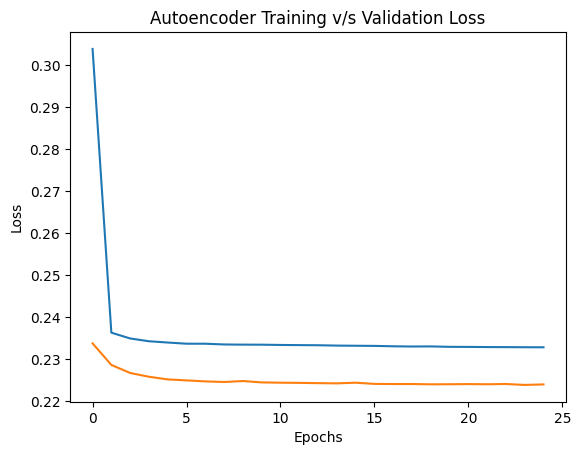

In [ ]:
# Autoencoder Training and Validation Loss plot
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Autoencoder Training v/s Validation Loss")

# Freezing Autoencoder layers
for layer in autoencoder.layers:
    layer.trainable = False
    print(layer.name, layer.trainable)

In [ ]:
# Testing output of autoencoder versus actual image
y_pred = autoencoder.predict(combined_images)

fig, axes = plt.subplots(1,2, figsize=(8,5))
idx = 109
axes[0].imshow(combined_images[idx], cmap='grey')
axes[0].set_title('original_image')
axes[0].axis('off')
axes[1].imshow(y_pred[idx], cmap='grey')
axes[1].set_title('generated_image')
axes[1].axis('off')
plt.suptitle('Comparison of Original vs. AutoEncoder Generated Prediction');

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 model_15 (Functional)       (None, 128, 128, 3)       125315    
                                                                 
 conv2d_69 (Conv2D)          (None, 128, 128, 64)      6400      
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 128)       221312    
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                    

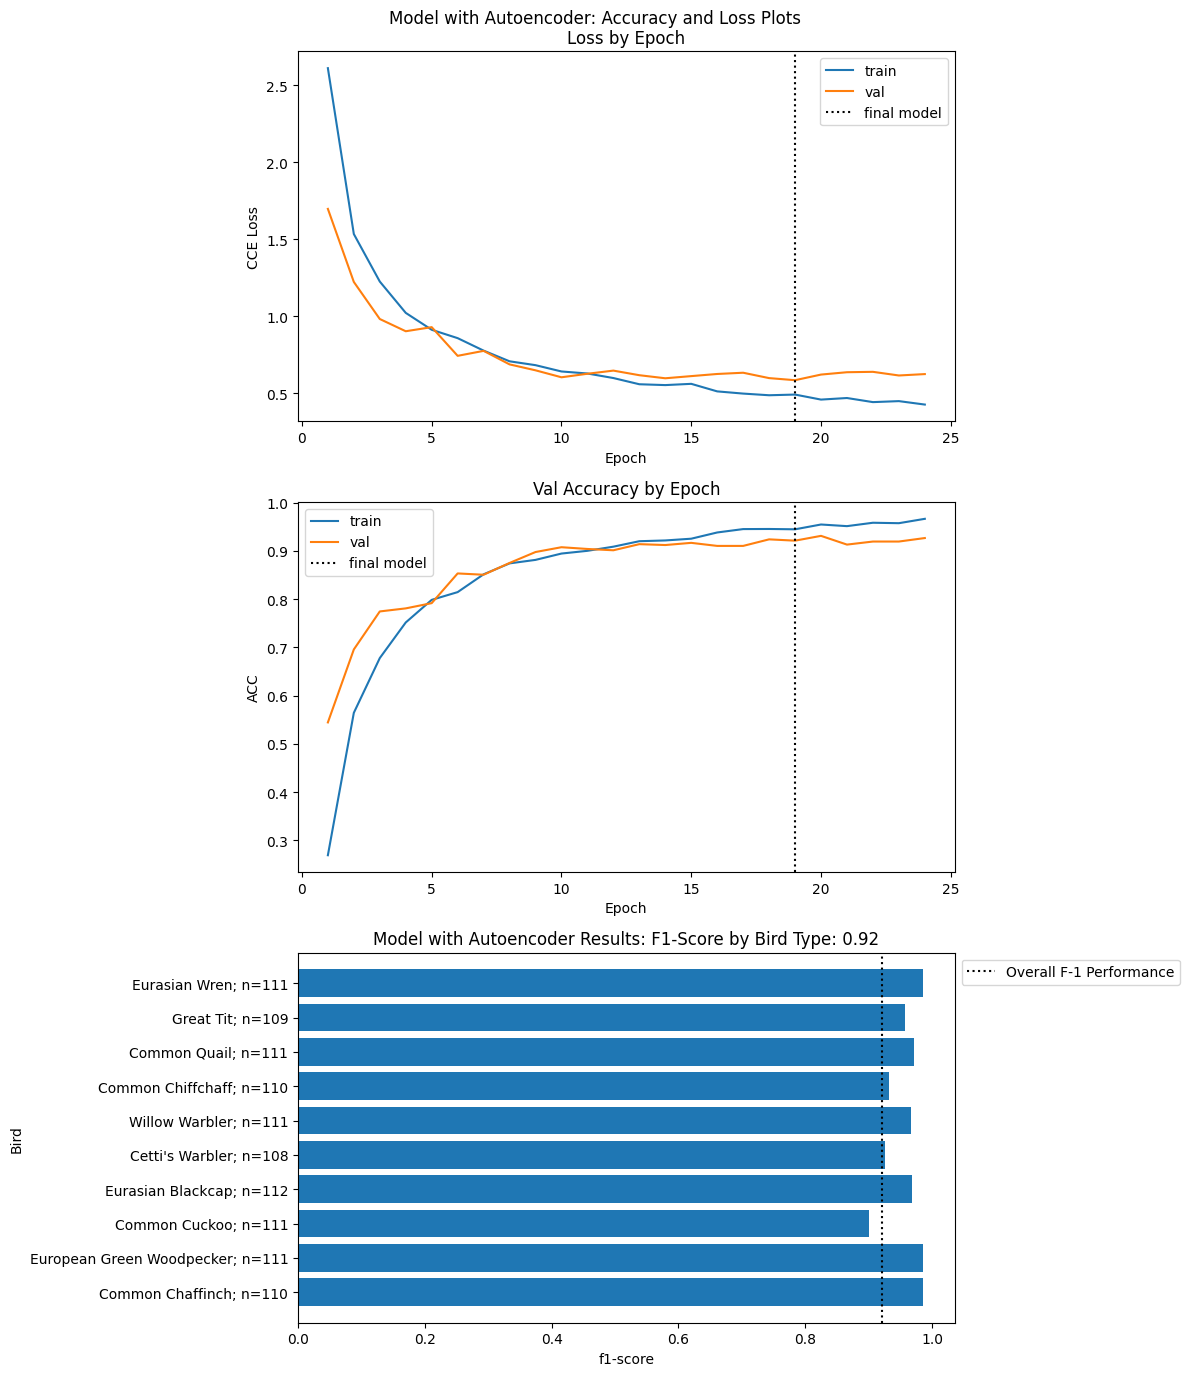

In [ ]:
def autoencoder_model(input_dim):

  n_classes = 10
  regularizer = 0.0001
  kernel_regularizer = L1(l1=regularizer)
  bias_regularizer = L1(l1=regularizer)

  inputs = Input(shape=(input_dim))

  x = autoencoder(inputs)

  x = Conv2D(64, (11,3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(128, (9,3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dense(256, activation= 'relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
  x = Dropout(0.5)(x)
  x = Dense(128, activation= 'relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
  x = Dropout(0.5)(x)

  outputs = Dense(n_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

input_dim = [128,128,3]
autoencoder_oversample = autoencoder_model(input_dim)
model_eval(autoencoder_oversample,train_data_2, val_data_2, valgen_df_2, name_to_index_2 , 30,'Model with Autoencoder')

### **5.f. Overview of Models**

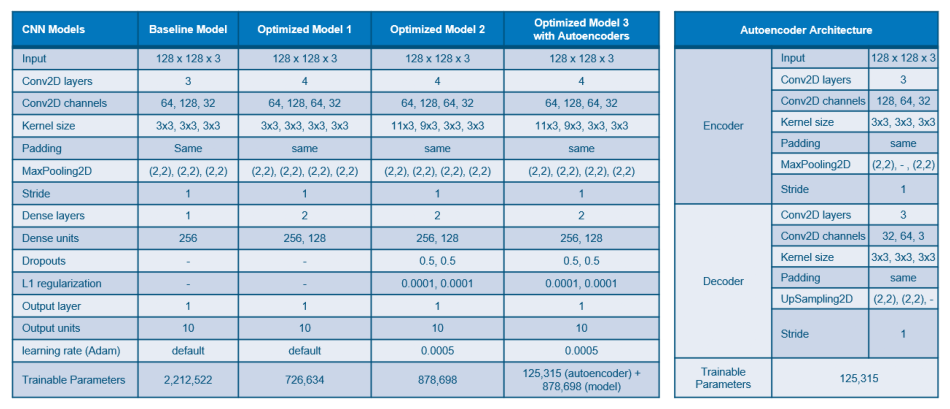

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/model_arch.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

# **6. Results Interpretation and Analysis**

In summary, our Optimized Model 2 provides the highest overall validation accuracy.  It has one of the lowest numbers of parameters, however the model ran for 30 epochs before achieving the best model predictions/weights.

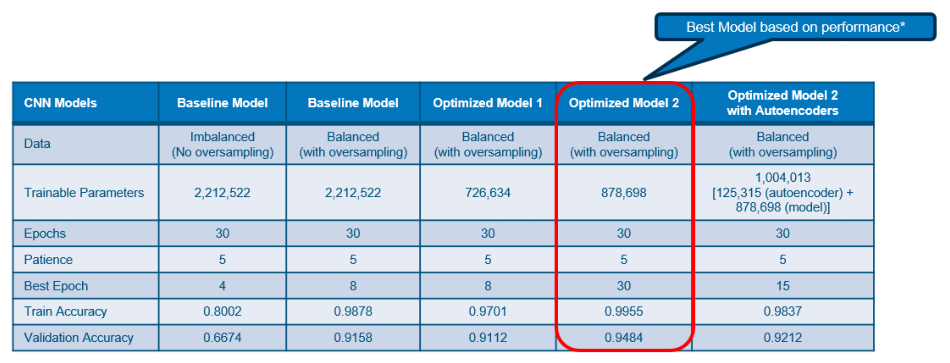

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/model_eval.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

The train and validation loss and accuracy curves follow closely, without significant overfitting of the train data.  Model parameters were optimized to ensure more consistent results when model is applied to novel data in the inference phase.

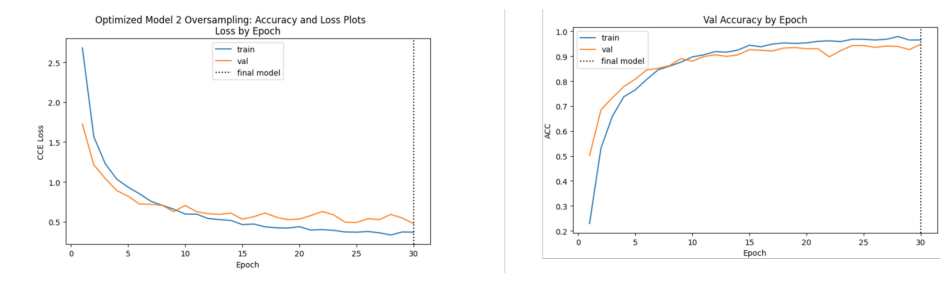

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/opt_2.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

Accuracy of the predictions by bird type were also explored by calculating the f1-score for each prediction category. In the case of our Optimized Model 2, we see a balanced prediction accuracy across all 10 classes.   Note that the oversampling of the data was one of our biggest imporvements in prediction accuracy, as underperforming classes were improved, raising overall accuracy scores.

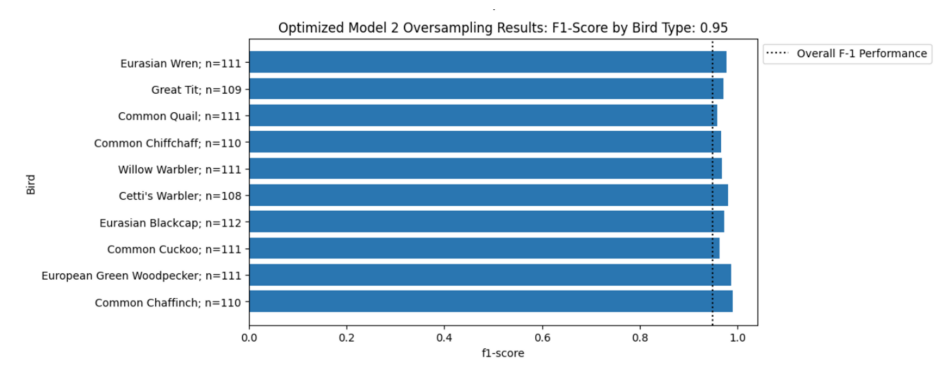

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/f1_score_opt_2.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

## **6.b.  Final Test Model Run & Ongoing Inference Expectations**

Our test sample was used to conduct our final inference on the Top 10 Bird Song cohort.  The final test accuracy of 95% was in line with our validation accuracy.   Similarly the F1-score for the 10 classes also were balanced with all classes over 90%.   Test accuracy results validated the consistency of our model performance on novel data.


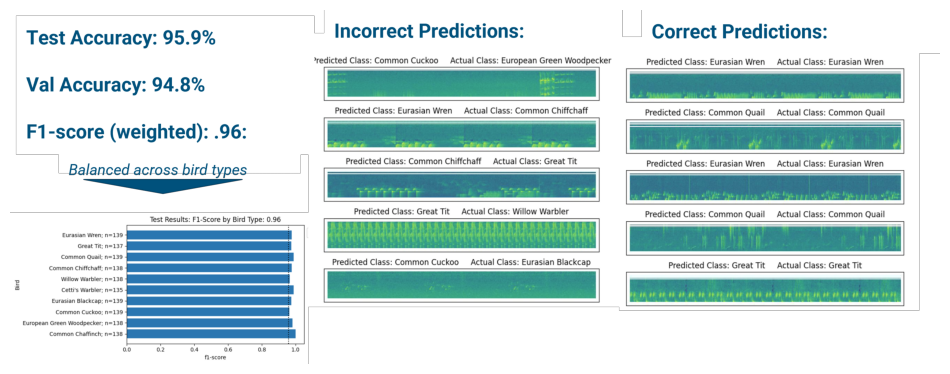

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/final_inference.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

### **Inference Results**

In [ ]:
# Evaluate test sample:
test_overall = regmodel_regoversample.evaluate(test_data_2)

87/87 [==============================] - 4s 46ms/step - loss: 0.4154 - accuracy: 0.9594


In [ ]:
# Generate predictions
test_predict = regmodel_regoversample.predict(test_data_2,steps = np.ceil(test_data_2.samples/test_data_2.batch_size))

predicted_class = np.argmax(test_predict,axis=1)

labels = (test_data_2.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class]

87/87 [==============================] - 4s 46ms/step


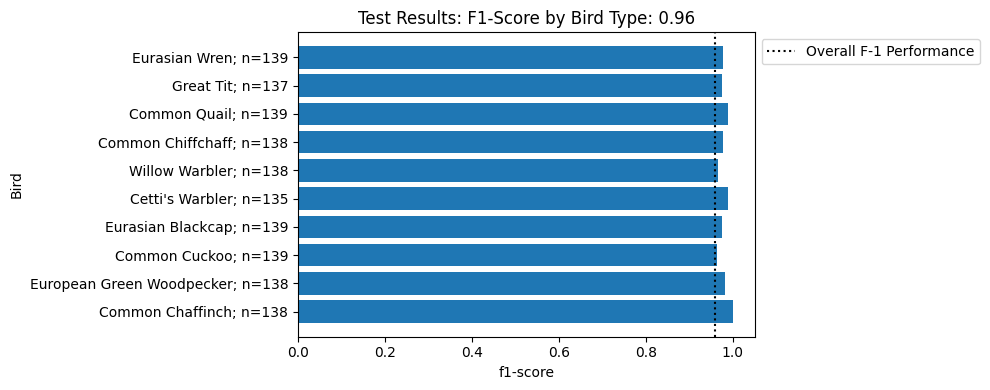

In [ ]:
  #####  Create a dataframe tracking results by file/sample
  filenames=test_data_2.filenames
  results=pd.DataFrame({"Filename":filenames,
                        "Fileshort":[f[-10:] for f in filenames],
                        "Predictions":predictions})

  results['Actual']= [list(testgen_df_2[testgen_df_2.x == i].y.values)[0] for i in results.Filename]
  results['Labels'] = test_data_2.labels

  #####  Calculate F1 Score:
  f1 = []
  count = []

  labels_list = list(labels.values())

  for i in np.arange(0,len(labels_list),1):
      val = results.Actual[results.Actual == labels_list[i]].dropna()
      pred = results.Predictions[results.Actual == labels_list[i]].dropna()
      helper = f1_score(val, pred, average = 'weighted')
      helper2 = len(val)
      f1.append(helper)
      count.append(helper2)

  overall = f1_score(results.Actual, results.Predictions, average='weighted')

  tags = [(t + f'; n={c}') for t,c in zip(list(name_to_index.keys()), count)]

  #####  Plot F1 Score:
  plt.rcParams["figure.figsize"] = (10,4)
  plt.barh(tags, f1)
  plt.axvline(overall, label = 'Overall F-1 Performance', color = 'black', linestyle = ':')
  plt.xlabel('f1-score')
  plt.ylabel('Bird')
  plt.title(f'Test Results: F1-Score by Bird Type: {round(overall,2)}')
  plt.legend(bbox_to_anchor=[1,1]);
  plt.tight_layout();


In [ ]:
#isolate indices of true vs. false classifcations:
actuals = testgen_df_2.y
mask = (actuals == predictions)

pred_series = pd.Series(predictions)

false_class = list(pred_series[mask == False].index)
true_class = list(pred_series[mask == True].index)

#Pick a few random samples from each group
false_random  = sample(false_class,5)
true_random  = sample(true_class,5)

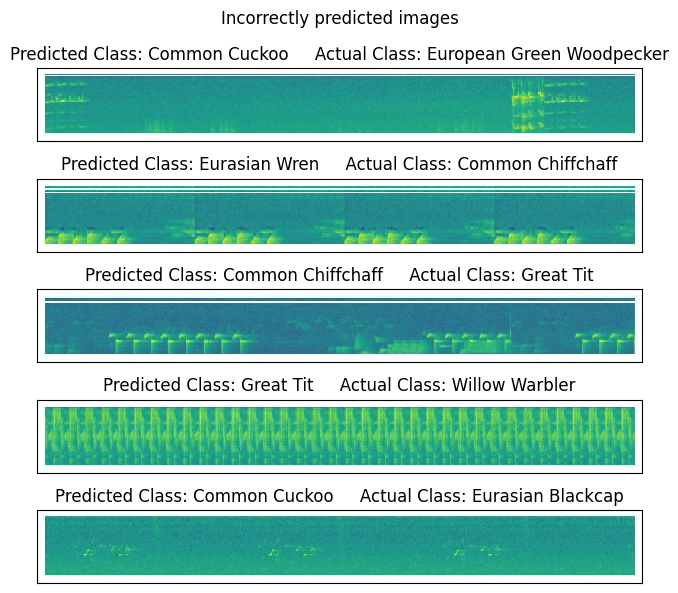

In [ ]:
fig, axs = plt.subplots(5,1, figsize = (14,6))
axs = axs.ravel();

for i in range(len(false_random)):
    img = mpimg.imread(testgen_df_2.x[false_random[i]])
    axs[i].imshow(img, cmap=plt.cm.gray,interpolation='nearest')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
    axs[i].set_title(f'Predicted Class: {index_to_name[int(predictions[false_random[i]])]}     Actual Class: {index_to_name[int(actuals[false_random[i]])]}')

plt.suptitle('Incorrectly predicted images')
plt.tight_layout()

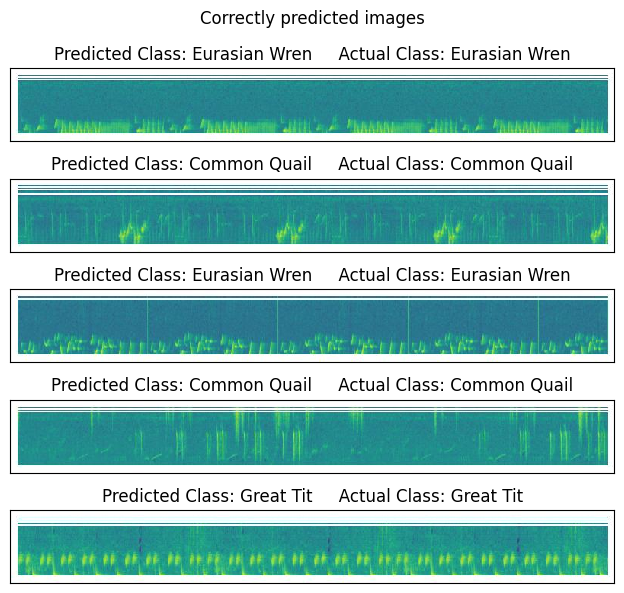

In [ ]:
fig, axs = plt.subplots(5,1, figsize = (14,6))
axs = axs.ravel();

for i in range(len(true_random)):
    img = mpimg.imread(testgen_df_2.x[true_random[i]])
    axs[i].imshow(img, cmap=plt.cm.gray,interpolation='nearest')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
    axs[i].set_title(f'Predicted Class: {index_to_name[int(predictions[true_random[i]])]}     Actual Class: {index_to_name[int(actuals[true_random[i]])]}')

plt.suptitle('Correctly predicted images')
plt.tight_layout()

# **7. Summary of Findings and Future Next Steps**

Our 10 Bird Song model acheived 95% in test accuracy using our final selected model, which is greater that the 85% benchmark that we defined at the start of our project.  While the model was tested on a narrow range of samples in order to perfect the sample generation pipeline and test model, the model also provides a foundation that can be expanded to broaden the model's prediction capabilities.

Additional extensions of the model are possible by incorporating additional samples to expand our problem statement to include additional species, bird behaviors, geographic locations.  For instance, Appendix 1 contains a model that expands the 10 Bird Song model to an additional 80 Bird Calls, still within Europe.  

Further, the foundational model is a base prediction of which of 10 birds are present in the recording.  This model could also be expanded to not only predict the vernacular name of the bird but also the type of sound that a bird is making, using the same learning process. For instance, Appendix 2 contains an adjustment to our Optimized Model architecture to include predictions of call and song, alongside the 10 bird vernacular names in our base model.  

Finally, while a relatively simplistic CNN-based model was capable of achieving a relative high accuracy, with additional data and classes, exploration of more robust architectures and transfer learning may be required to acheive similar accuracy results.


# **APPENDIX 1: Expansion to Top 80 CALLS and Top 10 SONGS**

**Objective:** Test our final model and data pipeline on both Top 10 Bird_song combinations as well as Top 80 Bird_call behaviors within Europe.

**Conclusions:**   Application of our final model from the Top 10 Bird Song data yields accuracy rates of 70% with a new sample size of additional 68 Bird Call combinations. Sample parameter tuning was required to cover ranges within call data to expand to appropriate frequency and decibel ranges. Additional tuning is required to ensure a balanced pool across all 90 samples, as 12 Bird_Call samples omitted entirely and several had lower sample sizes than our 700 cap.  

### **Sample Generation Pipeline**

35K original samples were oversampled with the goal of creating consistent groups of at most 700 samples. This cohort used the same hyperparameters to generate samples as our 10 Bird_song model. This model resulted in ~49K image samples, and ommitted data from 12 of the 90 bird_behavior combos being tested. Samples fail to generate if the noise filtering threshold is too high, or if the sound frequency or decible ranges are outside the paramters for the model. In research, bird calls occur at lower frequencies and may be higher decibles.     

Further adjustment is required as there is still significant sample omission for several bird_behavior groups and a small portion of resulting images have some white banding at the top.  Both of these challenges can be overcome by further paramter tuning within the sample generation process.

**Results with similar sample generation hyperparameters as 10 Bird_Song model**

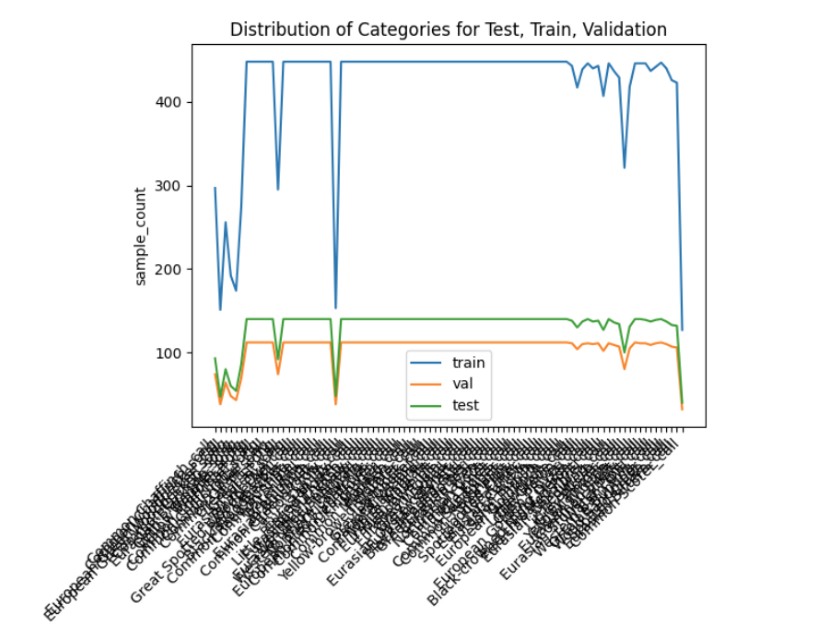

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/78_dist.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

### **Model Results**

The samples from our 78 remaining bird-behavior combinations were run through the Optimized Model 2, under similar specifications as our inital 10 Bird-song samples.  Additonal parameter tuning will be required in order to optimize model to additional samples.

**Initial Validation Accuracy: 70%**

**Initial Train Accuracy: 74%**

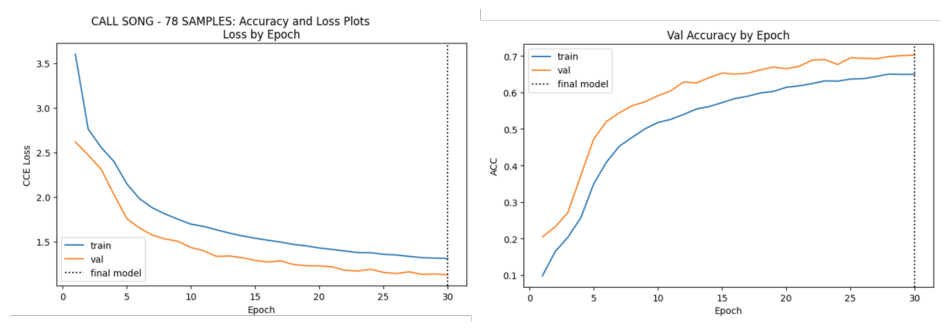

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/78_loss_acc.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

### **F1-Score Performance**

F1-Score performance varies widely across bird_behavior types. Sample irregularity may be part of the issue given many of the samples generated have white horizontal banding that may interfere with the learning process. Model accuracy should improve as image quality improves through further tuning and data coverage becomes more consistent across the bird_behavior categories.

**Results with similar sample generation hyperparameters as 10 Bird_Song model**

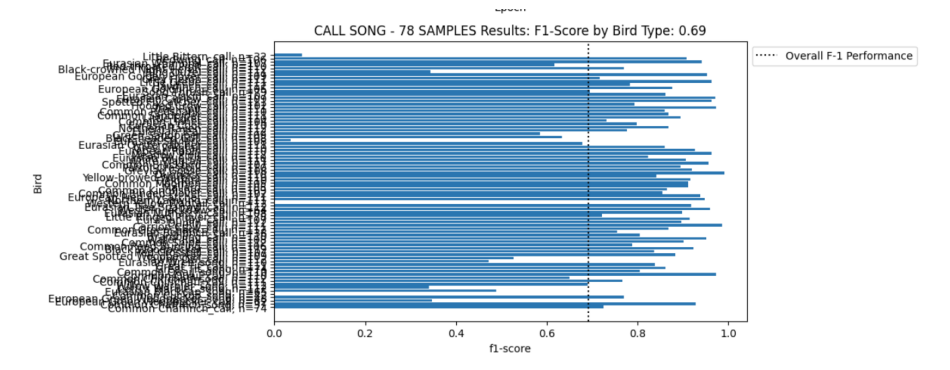

In [ ]:
img = mpimg.imread(os.path.join(base_path,'figures/78_f1_score.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

### **A1.A:Oversample 80 call and 10 song data frames**

In [ ]:
"""
#Import file for the songs and calls and oversample it:
call_song_top_df = pd.read_csv(os.path.join(base_path,"call_song_top_df.csv"), index_col = 0)

call_song_top_oversample_df = oversample(call_song_top_df)

#First time we created a file to archive list:
call_song_top_oversample_df.to_csv(os.path.join(base_path,"call_song_top_oversample_df.csv"), index = False)
"""

'\n#Import file for the songs and calls and oversample it:\ncall_song_top_df = pd.read_csv(os.path.join(base_path,"call_song_top_df.csv"), index_col = 0)\n\ncall_song_top_oversample_df = oversample(call_song_top_df)\n\n#First time we created a file to archive list:\ncall_song_top_oversample_df.to_csv(os.path.join(base_path,"call_song_top_oversample_df.csv"), index = False)\n'

### **A1.B: Generate New Samples for Additional Categories**

In [ ]:
"""
### Generate Image Samples for New Data
except_file_o, except_df_idx_o = bird_pipe_oversample(call_song_top_oversample_df,
              audio_write = False,  #Set if True you want to generate separate audio files in addition to pictures
              samp_rate = 22050,
              sec_to_keep = 15,
              epsilon = 0.15,
              spec_nftt = 512,
              spec_window =512,
              spec_stride = 256,
              mel_mels = 128,
              mel_fmin = 750,
              mel_fmax = 8000,
              db_scale_top_db = 70,
              aug_range = 0.01,   #Range that fmin, fmax, db_scale_top_db, epsilon will be change
              folder_name = '15s/mel_spec_call_song/')
"""

"\n### Generate Image Samples for New Data\nexcept_file_o, except_df_idx_o = bird_pipe_oversample(call_song_top_oversample_df,\n              audio_write = False,  #Set if True you want to generate separate audio files in addition to pictures\n              samp_rate = 22050,\n              sec_to_keep = 15,\n              epsilon = 0.15,\n              spec_nftt = 512,\n              spec_window =512,\n              spec_stride = 256,\n              mel_mels = 128,\n              mel_fmin = 750,\n              mel_fmax = 8000,\n              db_scale_top_db = 70,\n              aug_range = 0.01,   #Range that fmin, fmax, db_scale_top_db, epsilon will be change\n              folder_name = '15s/mel_spec_call_song/')\n"

In [ ]:
"""
#Exceptions Monitoring:
#flag in df
call_song_top_oversample_df['exceptions'] = [True if i in except_file_o else False for i in call_song_top_oversample_df.file_name]

#calculate lost by bird type
lost_by_type = call_song_top_oversample_df[call_song_top_oversample_df.exceptions == True].vernacularName.value_counts()

print(f'Records lost: {len(except_file_o)}')
display(lost_by_type)
"""

"\n#Exceptions Monitoring:\n#flag in df\ncall_song_top_oversample_df['exceptions'] = [True if i in except_file_o else False for i in call_song_top_oversample_df.file_name]\n\n#calculate lost by bird type\nlost_by_type = call_song_top_oversample_df[call_song_top_oversample_df.exceptions == True].vernacularName.value_counts()\n\nprint(f'Records lost: {len(except_file_o)}')\ndisplay(lost_by_type)\n"

In [ ]:
"""
#Save to .csv for future use
call_song_top_oversample_df.to_csv(os.path.join(base_path,"call_song_top_oversample_df.csv"), index = False)
"""

'\n#Save to .csv for future use\ncall_song_top_oversample_df.to_csv(os.path.join(base_path,"call_song_top_oversample_df.csv"), index = False)\n'

### **A1.C: Datagen Pipeline for Model**

In [ ]:
"""
#### Add the VernacularName, Call/Song Flag back in the data set
call_song_top_oversample_df = pd.read_csv(os.path.join(base_path,'call_song_top_oversample_df.csv'))
call_song_top_df = pd.read_csv(os.path.join(base_path,'call_song_top_df.csv'))

mod_df = pd.merge(left=call_song_top_oversample_df,right=call_song_top_df, left_on='gbifID', right_on= 'gbifID', how = 'left')

mod_df = mod_df.loc[:,['gbifID', 'format_x', 'duration_seconds_x', 'bird_behavior', 'file_name',
       'exceptions',]]

mod_df.columns = ['gbifID', 'format', 'duration_seconds', 'vernacularName', 'file_name',
       'exceptions']

#mod_df['exceptions'] = [False for i in mod_df['exceptions']]

## Count
bird_count = len(mod_df.vernacularName.unique())
"""

In [ ]:
"""
###  Image Data Generator for Oversampling
folder_name = '15s/mel_spec_call_song/'
image_width = 128
image_height = 128
train_batch_size = 32

train_data_4, test_data_4, val_data_4,valgen_df_4,testgen_df_4,name_to_index_4 = cnn_prep_pipeline(mod_df,
                                                                                                   folder_name = folder_name,image_width = image_width, image_height = image_height, train_batch_size = train_batch_size)
"""

"\n###  Image Data Generator for Oversampling\nfolder_name = '15s/mel_spec_call_song/'\nimage_width = 128\nimage_height = 128\ntrain_batch_size = 32\n\ntrain_data_4, test_data_4, val_data_4,valgen_df_4,testgen_df_4,name_to_index_4 = cnn_prep_pipeline(mod_df,\n                                                                                                   folder_name = folder_name,image_width = image_width, image_height = image_height, train_batch_size = train_batch_size)\n"

### **A1.D:  Call Final Optimized Model and Use on New Samples**

In [ ]:
"""
def optimized_model2(input_dim,n_classes):

  # Regularize Model Code
  n_classes = n_classes
  regularizer = 0.0001
  kernel_regularizer = L1(l1=regularizer)
  bias_regularizer = L1(l1=regularizer)
  inputs = Input(shape=(input_dim))

  x = Conv2D(64, (11, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(128, (9, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)


  x = Flatten()(x)
  x = Dense(256, activation= 'relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
  x = Dropout(0.5)(x)
  x = Dense(128, activation= 'relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
  x = Dropout(0.5)(x)


  outputs = Dense(n_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model
  """

In [ ]:
"""
input_dim = [128,128,3]
optmodel_78_optoversample = optimized_model2(input_dim,78)
model_eval(optmodel_78_optoversample,train_data_4, val_data_4, valgen_df_4,name_to_index_4,30,'CALL SONG - 78 SAMPLES')
"""

"\ninput_dim = [128,128,3]\noptmodel_78_optoversample = optimized_model2(input_dim,78)\nmodel_eval(optmodel_78_optoversample,train_data_4, val_data_4, valgen_df_4,name_to_index_4,30,'CALL SONG - 78 SAMPLES')\n"

# **APPENDIX 2:  Additional Sample Augmentation with Call and Song for Top 10 Song bird**



**Objective**: expand the project scope to both song and call behaviors within Europe for the top 10 song birds. Increase the number of samples for both behaviors by including additional samples from the original data. Aim for 700 samples per bird type for both song and call (which is the amount of samples the majority song category, Cetti's Warbler, has). Oversampling will be used to make up differences where not enough data is obtained.

Finally, modify the pipeline and models to incorporate 2 targets: bird type and behavior (song/call). By observing the impact of adding more data and increasing the classification task, we will get valuable insights on future improvements.

**Conclusion**: An average F1 score of 86% and 99% for bird types and behaviors could be achieved, respectively (accuracies: 85% and 99% for test without noteable overfitting). However, this not only required pulling additional data from our data set (by expanding filters), but also ensuring that both song and call data have enough extra augmented data. In adition, the model architecture had to be modified and the mel frequency ranges and had to be tuned precisely for calls, especially as even small variations (when augmenting data) could lead to no distorted images. As concluded in Appendix 1, already further research on audio parameters would improve results and perhaps eliminate the need to use a more complex model architecture as done here.

### **1. Gain additional data**
The data is filtered to obtain new bird samples:

* Data after 2010 with duration > 15 seconds and <= 60 seconds
* Data between 2007-2010 (not including the latter) with length <= 60 seconds
* Data after 2010 with length <= 15 seconds with non-exact matching (as opposed to only exact matches defined previously, e.g. 'songsong') - gives a few extra samples


Below is the distribution breakdown and the amount of additional samples that are required for song per class. Cetti's Warbler is the dominating song class and therefore needs no additional samples. In terms of calls, 700 need to be added for all bird types, to match the maximum number of songs. <br> <br>

*vernacularName* (sample numbers are approximate, may differ by a few which can be ignored since oversampling will be used to make up the numbers)

- Cetti's Warbler              
    * approx. 700 song data, maximum amount per bird type
- Eurasian Wren                
    * 332 song data, requires an increase of ±368 song samples
- Common Cuckoo                
    * 308 song data, requires an increase of ±392 song samples
- Great Tit                    
    * 260 song data, requires an increase of ±440 song samples
- Willow Warbler               
    * 233 song data, requires an increase of ±467 song samples
- Common Chiffchaff            
    * 230 song data, requires an increase of ±470 song samples
- Eurasian Blackcap            
    * 229 song data, requires an increase of ±471 song samples
- Common Quail                 
    * 215 song data, requires an increase of ±485 song samples
- Common Chaffinch             
    * 211 song data, requires an increase of ±489 song samples
- European Green Woodpecker    
    * 169 song data, requires an increase of ±531 song samples

In [ ]:
# Subset the occurrence dataframe as we did in pre-processing
# Data between 2007-2010 (not including the latter)

occ_selected_df = occ_df[(occ_df['year']>=2007)
                          &(occ_df['year']<2010)
                          &(occ_df['identificationRemarks'].isna())][["gbifID","collectionCode","basisOfRecord","behavior","associatedTaxa","continent","countryCode",
                          "verbatimElevation","decimalLatitude","decimalLongitude","scientificName","higherClassification",
                          "kingdom","phylum","class","order","family","genus","genericName","specificEpithet","taxonRank",
                          "vernacularName","taxonomicStatus","species","gbifRegion","level0Name","level1Name","level2Name",
                          "level3Name", "sex", "lifeStage"]]

In [ ]:
# Data after 2010
year_after_10 = occ_df[(occ_df['year']>=2010) & (occ_df['identificationRemarks'].isna())][["gbifID","collectionCode","basisOfRecord","behavior","associatedTaxa","continent","countryCode",
                          "verbatimElevation","decimalLatitude","decimalLongitude","scientificName","higherClassification",
                          "kingdom","phylum","class","order","family","genus","genericName","specificEpithet","taxonRank",
                          "vernacularName","taxonomicStatus","species","gbifRegion","level0Name","level1Name","level2Name",
                          "level3Name", "sex", "lifeStage"]]


In [ ]:
# Get multimedia data (audio data) for the data after 2010
merged_df_after_10 = pd.merge(multi_selected_df, year_after_10, on = 'gbifID', how = 'left')

In [ ]:
# Recrodings after 2010 longer than 15 seconds
merged_df_after_10 = merged_df_after_10[merged_df_after_10['duration_seconds']>15]

In [ ]:
# Get multimedia data (audio data) for the data after between 2007 and 2010
merged_df = pd.merge(multi_selected_df, occ_selected_df, on = 'gbifID', how = 'left')

In [ ]:
# Now we have a dataframe that holds data after 2010 longer than 15 seconds, and data between 2007 and 2010
merged_df = pd.concat([merged_df, merged_df_after_10], ignore_index=True)

In [ ]:
# Repeat previous step to also get data >= 2010 that is shorter or equal to 15 seconds
merged_df_after_10 = pd.merge(multi_selected_df, year_after_10, on = 'gbifID', how = 'left')
merged_df_after_10 = merged_df_after_10[merged_df_after_10['duration_seconds']<=15]

In [ ]:
# Concatenate again so that the dataframe now holds all 3 filter conditions
merged_df = pd.concat([merged_df, merged_df_after_10], ignore_index=True)

In [ ]:
# Use filters from pre-processing and duration <= 60 seconds due to resource constraints
proposed_df = merged_df[(merged_df['continent']=='EUROPE') & (merged_df['duration_seconds']<= 60)]
proposed_df = proposed_df[proposed_df.vernacularName != 'Identity unknown']
proposed_df = proposed_df.dropna(subset=['behavior']) # needs to be filled

In [ ]:
# Keep only data where the behavior has call or song in it somewhere
behaviors = ['call', 'song']
proposed_df = proposed_df[proposed_df['behavior'].str.contains('|'.join(behaviors), case=False)]

In [ ]:
# If 'call' and 'song' occur together > label as such
# Else any string containing song will be labelled song, same for call
proposed_df['behavior'] = np.where(proposed_df['behavior'].str.contains('call') & proposed_df['behavior'].str.contains('song'),
                                   'song&call',
                                   np.where(proposed_df['behavior'].str.contains('call'),
                                            'call',
                                            np.where(proposed_df['behavior'].str.contains('song'),
                                                     'song',
                                                     proposed_df['behavior'])))

In [ ]:
# Use only the data from the top 10 song birds
subset = ["Cetti's Warbler",
'Eurasian Wren',
'Common Cuckoo',
'Great Tit',
'Willow Warbler',
'Common Chiffchaff',
'Eurasian Blackcap',
'Common Quail',
'Common Chaffinch',
'European Green Woodpecker']

proposed_df = proposed_df[proposed_df['vernacularName'].isin(subset)]

In [ ]:
# Get IDs of the subset we created and subtract the ones we already have
# (since we also subsetted >= 2010 and <= 15 seconds length, which was our original criteria)
# Leaves us with the final dataframe of all the new samples
ids = set()
song_original_ids = set(song_top10_df['gbifID'].values)
ids.update(set(proposed_df['gbifID'].values))
ids = ids - song_original_ids - song_original_ids
proposed_df = proposed_df[proposed_df['gbifID'].isin(ids)]

In [ ]:
# Show the number of additional samples available per class, per behavior
# Some are too many, others are not enough
# Not enough can be dealt with through oversampling, those with too many are filtered
# until they are approx. at the right amount
# Note: we are not using song&call as they represent both behaviors in one recording
pd.DataFrame(proposed_df.groupby(['vernacularName', 'behavior'])['gbifID'].count())

gbifID
vernacularName            behavior         
Cetti's Warbler           call          280
                          song          245
                          song&call      63
Common Chaffinch          call         1593
                          song         1160
                          song&call     272
Common Chiffchaff         call         1970
                          song         1042
                          song&call     221
Common Cuckoo             call          237
                          song          490
                          song&call     258
Common Quail              call          416
                          song          272
                          song&call      80
Eurasian Blackcap         call          580
                          song         1280
                          song&call     107
Eurasian Wren             call          996
                          song          876
                          song&call      59
European Green Woodpecker call          488
                          song           64
                          song&call      34
Great Tit                 call         2542
                          song         1223
                          song&call     183
Willow Warbler            call          425
                          song         1151
                          song&call     165

Filter the data further so that the approximate amount of data needed is reached (if there is not enough data, just take that):

In [ ]:
cettis_warbler_call = proposed_df[(proposed_df['vernacularName']=="Cetti's Warbler")
& (proposed_df['behavior'] == 'call')]
print("Call Cetti's Warbler: ", cettis_warbler_call.shape[0])

Call Cetti's Warbler:  280


In [ ]:
egw_call = proposed_df[(proposed_df['vernacularName']=='European Green Woodpecker')
& (proposed_df['behavior'] == 'call')]

egw_song = proposed_df[(proposed_df['vernacularName']=='European Green Woodpecker')
& (proposed_df['behavior'] == 'song')]

print('Song European Green Woodpecker: ', egw_song.shape[0])
print('Call European Green Woodpecker: ', egw_call.shape[0])

Song European Green Woodpecker:  64
Call European Green Woodpecker:  488


In [ ]:
common_chaffinch_call = proposed_df[(proposed_df['vernacularName']=='Common Chaffinch')
& (proposed_df['duration_seconds'] <= 21)
& (proposed_df['behavior'] == 'call')]

common_chaffinch_song = proposed_df[(proposed_df['vernacularName']=='Common Chaffinch')
& (proposed_df['duration_seconds'] <= 33)
& (proposed_df['behavior'] == 'song')]

print('Song Common Chaffinch: ', common_chaffinch_song.shape[0])
print('Call Common Chaffinch: ', common_chaffinch_call.shape[0])

Song Common Chaffinch:  509
Call Common Chaffinch:  709


In [ ]:
common_quail_call = proposed_df[(proposed_df['vernacularName']=='Common Quail')
& (proposed_df['behavior'] == 'call')]

common_quail_song = proposed_df[(proposed_df['vernacularName']=='Common Quail')
& (proposed_df['behavior'] == 'song')]

print('Song Common Quail: ', common_quail_song.shape[0])
print('Call Common Quail: ', common_quail_call.shape[0])


Song Common Quail:  272
Call Common Quail:  416


In [ ]:
eurasian_blackcap_song = proposed_df[(proposed_df['vernacularName']=='Eurasian Blackcap')
& (proposed_df['duration_seconds'] <= 30)
& (proposed_df['behavior'] == 'song')]

eurasian_blackcap_call = proposed_df[(proposed_df['vernacularName']=='Eurasian Blackcap')
& (proposed_df['behavior'] == 'call')]

print('Song Eurasian Blackcap: ', eurasian_blackcap_song.shape[0])
print('Call Eurasian Blackcap: ', eurasian_blackcap_call.shape[0])

Song Eurasian Blackcap:  476
Call Eurasian Blackcap:  580


In [ ]:
common_chiffchaff_song = proposed_df[(proposed_df['vernacularName']=='Common Chiffchaff')
& (proposed_df['duration_seconds'] <= 33)
& (proposed_df['behavior'] == 'song')]

common_chiffchaff_call = proposed_df[(proposed_df['vernacularName']=='Common Chiffchaff')
& (proposed_df['duration_seconds'] <= 16)
& (proposed_df['behavior'] == 'call')]

print('Song Common Chiffchaff: ', common_chiffchaff_song.shape[0])
print('Call Common Chiffchaff: ', common_chiffchaff_call.shape[0])

Song Common Chiffchaff:  476
Call Common Chiffchaff:  706


In [ ]:
willow_warbler_song = proposed_df[(proposed_df['vernacularName']=='Willow Warbler')
& (proposed_df['duration_seconds'] <= 32)
& (proposed_df['behavior'] == 'song')]

willow_warbler_call = proposed_df[(proposed_df['vernacularName']=='Willow Warbler')
& (proposed_df['behavior'] == 'call')]

print('Song Willow Warbler: ', willow_warbler_song.shape[0])
print('Call Willow Warbler: ', willow_warbler_call.shape[0])

Song Willow Warbler:  480
Call Willow Warbler:  425


In [ ]:
great_tit_song = proposed_df[(proposed_df['vernacularName']=='Great Tit')
& (proposed_df['duration_seconds'] <= 29)
& (proposed_df['behavior'] == 'song')]

great_tit_call = proposed_df[(proposed_df['vernacularName']=='Great Tit')
& (proposed_df['duration_seconds'] <= 18)
& (proposed_df['behavior'] == 'call')]

print('Great Tit Song: ', great_tit_song.shape[0])
print('Great Tit Call: ', great_tit_call.shape[0])

Great Tit Song:  444
Great Tit Call:  723


In [ ]:
common_cuckoo_song = proposed_df[(proposed_df['vernacularName']=='Common Cuckoo')
& (proposed_df['duration_seconds'] <= 44)
& (proposed_df['behavior'] == 'song')]

common_cuckoo_call = proposed_df[(proposed_df['vernacularName']=='Common Cuckoo')
& (proposed_df['behavior'] == 'call')]


print('Common Cuckoo Song: ', common_cuckoo_song.shape[0])
print('Common Cuckoo Call: ', common_cuckoo_call.shape[0])

Common Cuckoo Song:  393
Common Cuckoo Call:  237


In [ ]:
eurasian_wen_song = proposed_df[(proposed_df['vernacularName']=='Eurasian Wren')
& (proposed_df['duration_seconds'] <= 31)
& (proposed_df['behavior'] == 'song')]

eurasian_wen_call = proposed_df[(proposed_df['vernacularName']=='Eurasian Wren')
& (proposed_df['duration_seconds'] <= 33)
& (proposed_df['behavior'] == 'call')]

print('Eurasian Wen Song: ', eurasian_wen_song.shape[0])
print('Eurasian Wen Call: ', eurasian_wen_call.shape[0])

Eurasian Wen Song:  375
Eurasian Wen Call:  706


**Total amount of new data for song and call**

In [ ]:
ids_for_download_call = []
for df in [egw_call, great_tit_call, common_quail_call, eurasian_wen_call,
           common_cuckoo_call, willow_warbler_call, eurasian_blackcap_call,
           common_chiffchaff_call, common_chaffinch_call, cettis_warbler_call]:
    ids_for_download_call.extend(df['gbifID'].values)

len(ids_for_download_call)

5270

In [ ]:
ids_for_download_song = []
for df in [egw_song, great_tit_song, common_quail_song, eurasian_wen_song,
           common_cuckoo_song, willow_warbler_song, eurasian_blackcap_song,
           common_chiffchaff_song, common_chaffinch_song]:
    ids_for_download_song.extend(df['gbifID'].values)

len(ids_for_download_song)

3489

In [ ]:
# Save all extra samples in csv
# proposed_df[proposed_df['gbifID'].isin(ids_for_download_call + ids_for_download_song)].to_csv(base_path+'/extra_samples.csv')

In [ ]:
# Necessary for the whole audio link to be accessible
pd.set_option('display.max_colwidth', None)

The code below was used to get the new audio samples.

```
save_directory = '/content/drive/MyDrive/CS109B/data/mp3_new_samples_call'

ids_for_download = ids_for_download_call # repeat for song

for id in ids_for_download:
    audio_url = proposed_df[proposed_df['gbifID'] == id]['identifier'].values[0]
    response = requests.get(audio_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        filename = f'{id}.mp3'
        filepath = os.path.join(save_directory, filename)

        # Save the audio file locally
        with open(filepath, 'wb') as audio_file:
            audio_file.write(response.content)
    else:
        print(f'Failed to download audio file for id {id}. Status code: {response.status_code}')
```



### **2. Oversample the difference that remains after adding the new data. Generate spectrograms for both the new data and additional oversampled data.**

The code below comes from the data pipeline, with small modifications to allow for double classification. With it, we arrive at the final sample numbers in train, test and validation shown below.

Expand the code below to see an image summarizing the final train, validation and test sample sizes.





In [ ]:
# Sandras path = '/content/drive/MyDrive/New Folder/CS109B'
# Necessary because the original base_path variable references the data folder
base_path_109b_folder = '/content/drive/MyDrive/New Folder/CS109B'

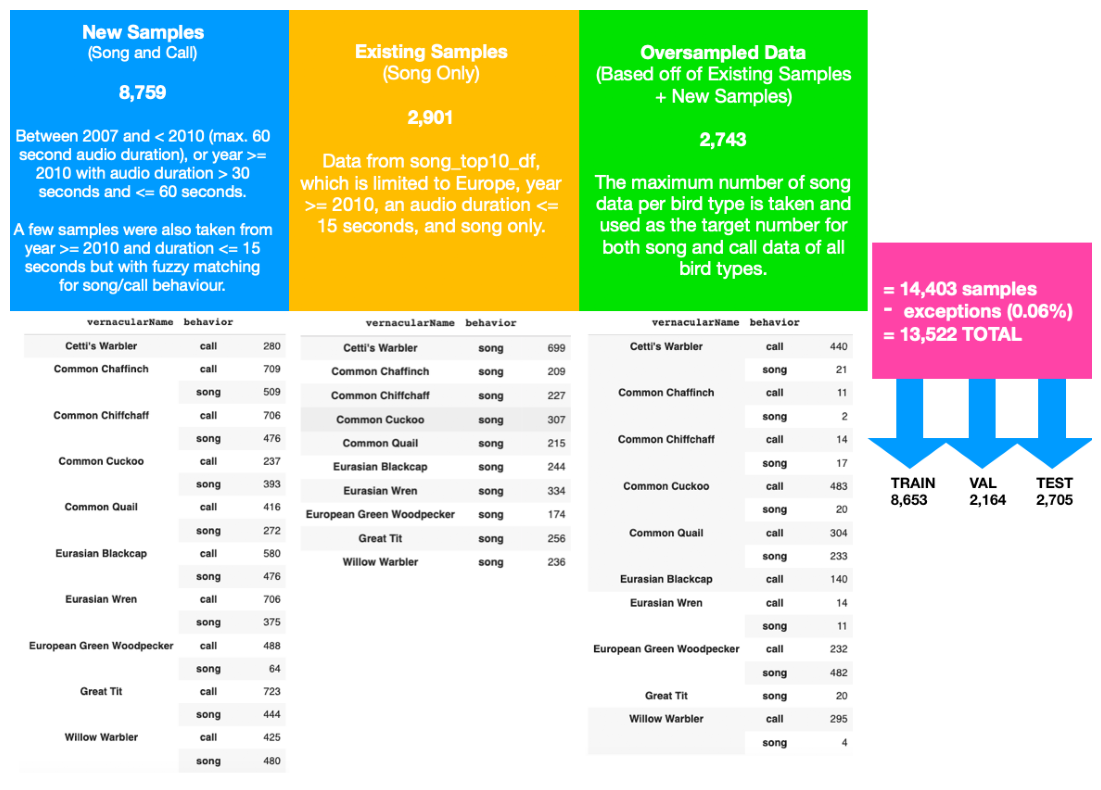

In [ ]:
img = mpimg.imread(base_path_109b_folder + '/figures/final_samples.png')
plt.figure(figsize=(14, 10))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
song_top10_df = pd.read_csv(base_path + "/song_top10_df.csv", index_col=0)
new_samples_only = pd.read_csv(base_path + "/extra_samples.csv", index_col=0)

In [ ]:
# How many original samples did we have and how many new ones are there?
song_top10_df.shape[0], new_samples_only.shape[0]

(2901, 8759)

In [ ]:
# Spectrogram images folder has seperate folders with images, need to specify for later which one in the file_name
new_samples_only['file_name'] = ['new_samples/' + str(x) for x in new_samples_only['gbifID'].values]
song_top10_df['file_name'] = ['mel_spec/' + str(x) for x in song_top10_df['gbifID'].values]

In [ ]:
# Concatenate the new samples with the previous song data to create a new point of truth
# This is the dataset that will be used to do oversampling
call_song_df = pd.concat([new_samples_only, song_top10_df],
                          ignore_index=True)

del new_samples_only
del song_top10_df

In [ ]:
# Repeat one more time since the song_top10_df file did not group the behaviors
call_song_df['behavior'] = np.where(call_song_df['behavior'].str.contains('call') & call_song_df['behavior'].str.contains('song'),
                                   'song&call',
                                   np.where(call_song_df['behavior'].str.contains('call'),
                                            'call',
                                            np.where(call_song_df['behavior'].str.contains('song'),
                                                     'song',
                                                     call_song_df['behavior'])))

In [ ]:
def oversample(df):
    """Gives a dataframe of samples needed to balance all bird classes. These samples will be used to generate new ones."""
    new_ids = []
    vern_names = []
    dur = []
    audio_type = []
    behavior = []

    # What's the max sample value for song data:
    max_value = max(df[df['behavior']=='song']['vernacularName'].value_counts())

    # Unique names to sample
    unique_names = df.vernacularName.unique()

    # Loop through target classes and randomly sample to create equal classes
    for name in unique_names:
        # Get dataframes for 'call' and 'song' behaviors
        call_df = df[(df.vernacularName == name) & (df['behavior'] == 'call')].reset_index()
        song_df = df[(df.vernacularName == name) & (df['behavior'] == 'song')].reset_index()

        # Calculate the number of additional samples needed
        call_samples_needed = max_value - len(call_df)
        song_samples_needed = max_value - len(song_df)

        # Randomly sample from each dataframe to match the maximum value
        for _ in range(call_samples_needed):
            idx = np.random.randint(0, len(call_df))
            new_ids.append(call_df.loc[idx, 'gbifID'])
            vern_names.append(call_df.loc[idx, 'vernacularName'])
            dur.append(call_df.loc[idx, 'duration_seconds'])
            audio_type.append(call_df.loc[idx, 'format'])
            behavior.append(call_df.loc[idx, 'behavior'])

        for _ in range(song_samples_needed):
            idx = np.random.randint(0, len(song_df))
            new_ids.append(song_df.loc[idx, 'gbifID'])
            vern_names.append(song_df.loc[idx, 'vernacularName'])
            dur.append(song_df.loc[idx, 'duration_seconds'])
            audio_type.append(song_df.loc[idx, 'format'])
            behavior.append(song_df.loc[idx, 'behavior'])

    # Create new df with oversampled values
    oversampled_data = pd.DataFrame({
        'gbifID': new_ids,
        'format': audio_type,
        'duration_seconds': dur,
        'vernacularName': vern_names,
        'behavior': behavior
    })

    # Add file_name column
    idx_ct = np.arange(0, len(df), 1)
    oversampled_data['file_name'] = [f'{x}_{y}' for x, y in zip(oversampled_data.gbifID, idx_ct)]

    # Save to CSV
    #song_top10_oversample_df.to_csv(os.path.join(base_path, "song_top10_oversample_df.csv"), index=False)
    return oversampled_data

In [ ]:
# oversample(song_and_call_df)

In [ ]:
# Modifications: bird calls are set to lower frequency (lower mel_fmin), and Epsilon is varied more instead of
# mel_fmin and mel_fmax as strong variations can create partially or fully blank spectrograms

def bird_pipe_oversample(song_top10_oversample_df,
              audio_write = False,
              samp_rate = 22050,
              sec_to_keep = 15,
              epsilon = 0.15,
              spec_nftt = 512,
              spec_window =512,
              spec_stride = 256,
              mel_mels = 128,
              mel_fmin = 750,
              mel_fmax = 8000,
              db_scale_top_db = 70,
              mel_range = 0.01,
              epsilon_range = 0.5,
              folder_name = 'sandra_wip/',
              directories = ['/mp3', '/mp3_new_samples', '/mp3_new_samples_call'],
              oversample=True):

    """Either creates new samples from basis samples in a dataframe or uses existing ones. oversample=False will just generate mel spectrograms
    for existing audios, while oversample=True will create new (fake) audio samples and corresponding spectrograms. If oversample=False, also set the
    epsilon_range and mel_range to 0."""

    dir_mp3 = [x[:-4] for x in os.listdir(base_path + directories[0])]

    except_file = []
    except_df_idx = []

    desired_length = samp_rate * sec_to_keep

    #Directory to save work products
    mel_spec_dir = os.path.join(base_path,f'{folder_name}')

    for i in tqdm(range(len(song_top10_oversample_df))):
    #for i in tqdm(range(10)):  #To test with 10 samples  ### Used to test a finite set of samples

        # Augment ranges of variables
        behavior = song_top10_oversample_df.iloc[i,4]

        if behavior == 'call':
            mel_fmin = 1500
            mel_fmax = 7000

        if not oversample:
            mel_range = 0
            epsilon_range = 0

        factor_mel = np.round(np.random.uniform(-mel_range,mel_range),3)
        factor_epsilon = np.round(np.random.uniform(-epsilon_range,epsilon_range),3)
        mel_fmin = mel_fmin * (1+(factor_mel))
        mel_fmax = mel_fmax * (1+(factor_mel))
        db_scale_top_db = db_scale_top_db * (1+factor_mel)
        epsilon = epsilon * (1+factor_epsilon)

        try:
            bird_id = song_top10_oversample_df.iloc[i,0]
            if oversample:
                filename = song_top10_oversample_df.iloc[i,5]
            else:
                filename = bird_id

            # which mp3 directory is the recording in?
            if behavior == 'call':
                directory = directories[-1]

            else:
                if str(bird_id) in dir_mp3:
                    directory = directories[0]
                else:
                    directory = directories[1]

            if song_top10_oversample_df.iloc[i,1] == 'audio/mpeg':
                audio = tfio.audio.AudioIOTensor(f'{base_path}{directory}/{bird_id}.mp3')
                audio_sample = audio.to_tensor()
            else:
                audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f'wav/{bird_id}.wav'))
                audio_sample = audio.to_tensor()
                audio_sample = tf.cast(audio_sample, tf.float32)

            audio_sampling_rate = audio.rate.numpy()

            #Flatten and mean balance
            if len(audio_sample.shape) > 1 and audio_sample.shape[-1] == 2:
                audio_sample = tf.reduce_mean(audio_sample,-1)
            else:
                audio_sample = tf.squeeze(audio_sample, axis=-1)

            #Adjust sampling rate to the rate in the file
            audio_sample = tfio.audio.resample(audio_sample, rate_in=audio_sampling_rate, rate_out=samp_rate)

            #Normalize (1, -1)
            audio_sample = librosa.util.normalize(audio_sample)

            #Trim portions with low baseline noise/no bird sound
            position = tfio.audio.trim(audio_sample, axis=0, epsilon=epsilon)
            start = position[0]
            stop = position[1]
            audio_sample = audio_sample[start:stop]


            if audio_sample.shape[0]< desired_length:
                loops = desired_length//audio_sample.shape[0]+1
                audio_sample_new = np.zeros((loops*audio_sample.shape[0],1)).astype('float32')

                for l in range(loops):
                    audio_sample_new[len(audio_sample)*l:(len(audio_sample)*l+len(audio_sample)),0] = audio_sample

                #clip to desired length and save
                audio_sample = audio_sample_new[:desired_length]

                if audio_write == True:
                  write(os.path.join(base_path,f'{folder_name}/audio_{filename}.wav'), samp_rate,audio_sample[:,0])

                #Create spectrogram
                spectrogram = tfio.audio.spectrogram(audio_sample[:,0], nfft=spec_nftt, window=spec_window, stride=spec_stride)

            elif audio_sample.shape[0]>= desired_length:
                audio_sample= audio_sample[:desired_length]
                #Create spectrogram
                spectrogram = tfio.audio.spectrogram(audio_sample, nfft=spec_nftt, window=spec_window, stride=spec_stride)
                if audio_write == True:
                  #save copy of file
                  write(os.path.join(base_path,f'{folder_name}/audio_{filename}.wav'), samp_rate,audio_sample)

            #Create mel_spectrogram
            plt.ioff()
            mel_spectrogram = tfio.audio.melscale(spectrogram, rate=samp_rate, mels=mel_mels, fmin=mel_fmin, fmax=mel_fmax)
            #Generate a plot to save
            plt.figure(figsize=(10, 4))
            plt.imshow(tf.math.log(mel_spectrogram).numpy().T)
            plt.axis('off')
            mel_spec_file = os.path.join(mel_spec_dir, f"{filename}.jpeg",)
            plt.savefig(mel_spec_file, bbox_inches='tight')
            plt.close()  # Close the plot to prevent memory leaks

            #Filter out high db sounds
            mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=db_scale_top_db)

        except Exception as e:
            print(e)
            #except_file.append(song_top10_oversample_df.iloc[i,5])
            except_df_idx.append(i)

        if i % 100 == 0:
            gc.collect() # To clear unused memory after every 100 iterations

    return except_file, except_df_idx


In [ ]:
# bird_pipe_oversample(oversampled_data, folder_name='sandra_wip/oversampled')
# The pipeline was also used to generate the additional call and song samples (not oversampled) by setting oversample to false
oversampled_data = pd.read_csv(base_path + '/oversampled_extra_data.csv')

In [ ]:
# Shows the number of oversampled samples created by category
pd.DataFrame(oversampled_data.groupby(['vernacularName', 'behavior'])['gbifID'].count())

gbifID
vernacularName            behavior        
Cetti's Warbler           call         440
                          song          21
Common Chaffinch          call          11
                          song           2
Common Chiffchaff         call          14
                          song          17
Common Cuckoo             call         483
                          song          20
Common Quail              call         304
                          song         233
Eurasian Blackcap         call         140
Eurasian Wren             call          14
                          song          11
European Green Woodpecker call         232
                          song         482
Great Tit                 song          20
Willow Warbler            call         295
                          song           4

In [ ]:
def get_exceptions(dataframe, folder_path, oversampled_df=True):
    """get exceptions that dont have images. Does not need to be used if the
    image loading function bird_pipe_oversample was used to save the ids already."""

    if oversampled_df:
        col = 'file_name'
        return set(dataframe[col].values) - set([x[:-5] for x in os.listdir(folder_path)])
    else:
        col = 'gbifID'
        return set([str(x) for x in dataframe[col].values]) - set([x[:-5] for x in os.listdir(folder_path)])

In [ ]:
exception_ids_oversampled = get_exceptions(oversampled_data, folder_path=base_path+'/sandra_wip/oversampled')
exception_ids_original = get_exceptions(call_song_df[call_song_df['file_name'].str.contains('mel_spec')],
                                        folder_path=base_path+'/sandra_wip/mel_spec',
                                        oversampled_df=False)
exception_ids_new_samples = get_exceptions(call_song_df[call_song_df['file_name'].str.contains('new_samples')],
                                        folder_path=base_path+'/sandra_wip/new_samples',
                                        oversampled_df=False)

In [ ]:
# Exceptions will be filtered out
call_song_df['exceptions'] = (call_song_df.gbifID.astype(str).isin(exception_ids_new_samples.union(exception_ids_original)) |
                              oversampled_data.file_name.isin(exception_ids_original))

oversampled_data['exceptions'] = oversampled_data.file_name.isin(exception_ids_oversampled)

In [ ]:
# % exceptions
print('Exceptions Call & Song Data: ', round(call_song_df['exceptions'].sum()/call_song_df.shape[0],2), '%')
print('Exceptions Oversampled Data: ', round(oversampled_data['exceptions'].sum()/oversampled_data.shape[0],2), '%')

Exceptions Call & Song Data:  0.06 %
Exceptions Oversampled Data:  0.06 %


### **3.  Modify the data generator to handle double classification**



In [ ]:
# This is necessary for the flow_from_dataframe data generation
oversampled_data['file_name'] = 'oversampled/' + oversampled_data.file_name

In [ ]:
# Combine everything into one dataframe
call_song_df = call_song_df[oversampled_data.columns] # ensure same number and order of columns
call_song_df = pd.concat([call_song_df, oversampled_data], ignore_index=True) # combine

In [ ]:
def cnn_prep_pipeline(song_top10_oversample_df,folder_name = 'wip/',image_width = 794, image_height = 96, train_batch_size = 16):
    #Add a test/train/validation/exception column to the song_top10_oversample_df:
    song_top10_oversample_split_df = song_top10_oversample_df.copy()
    song_top10_oversample_split_df['combined'] = song_top10_oversample_split_df.vernacularName +'_'+ song_top10_oversample_split_df.behavior

    cols_keep = ['gbifID','file_name','vernacularName','behavior', 'exceptions', 'combined']
    song_top10_oversample_split_df = song_top10_oversample_split_df.loc[:,cols_keep]

    song_top10_oversample_split_df = song_top10_oversample_split_df[song_top10_oversample_split_df.exceptions == False]


    temp_data, test_data = train_test_split(song_top10_oversample_split_df, test_size=0.2, stratify=song_top10_oversample_split_df.combined,
                                            random_state=109)

    train_data, val_data = train_test_split(temp_data, test_size=0.2, stratify=temp_data.combined,
                                            random_state=109)

    #append Test/Train/Val to the 'Flag' Column
    song_top10_oversample_split_df['train'] = [x in train_data.file_name.values for x in song_top10_oversample_split_df.file_name]
    song_top10_oversample_split_df['test'] = [x in test_data.file_name.values for x in song_top10_oversample_split_df.file_name]
    song_top10_oversample_split_df['val'] = [x in val_data.file_name.values for x in song_top10_oversample_split_df.file_name]

    # encode labels
    index_to_name = {i: name for i, name in enumerate(song_top10_oversample_split_df['vernacularName'].unique())}
    name_to_index = {name: i for i, name in enumerate(song_top10_oversample_split_df['vernacularName'].unique())}
    index_to_name_b = {i: name for i, name in enumerate(song_top10_oversample_split_df['behavior'].unique())}
    name_to_index_b = {name: i for i, name in enumerate(song_top10_oversample_split_df['behavior'].unique())}

    song_top10_oversample_split_df['y_bird'] = [name_to_index[x] for x in song_top10_oversample_split_df['vernacularName']]
    song_top10_oversample_split_df['y_behavior'] = [name_to_index_b[x] for x in song_top10_oversample_split_df['behavior']]

    link = [os.path.join(base_path,f'{folder_name}{i}.jpeg') for i in song_top10_oversample_split_df[song_top10_oversample_split_df.train==True].file_name]
    y_bird = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.train==True].y_bird]
    y_behavior = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.train==True].y_behavior]
    traingen_df = pd.DataFrame({'x':link,'y_bird':y_bird, 'y_behavior': y_behavior})

    link = [os.path.join(base_path,f"{folder_name}{i}.jpeg") for i in song_top10_oversample_split_df[song_top10_oversample_split_df.val==True].file_name]
    y_bird = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.val==True].y_bird]
    y_behavior = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.val==True].y_behavior]
    valgen_df = pd.DataFrame({'x':link,'y_bird':y_bird, 'y_behavior': y_behavior})

    #test
    link = [os.path.join(base_path,f"{folder_name}{i}.jpeg") for i in song_top10_oversample_split_df[song_top10_oversample_split_df.test==True].file_name]
    y_bird = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.test==True].y_bird]
    y_behavior = [i for i in song_top10_oversample_split_df[song_top10_oversample_split_df.test==True].y_behavior]
    testgen_df = pd.DataFrame({'x':link,'y_bird': y_bird, 'y_behavior': y_behavior})

    tf.random.set_seed(109)
    np.random.seed(109)

    # Generator for train and validation data
    image_generator = ImageDataGenerator(rescale=1./255)

    # SHUFFLE DATAFRAMES FIRST since they present data in order of category
    # but with random seed set so we will have the same results each time
    # training is shuffled in the image generator since it does not need to be the same
    #valgen_df = valgen_df.sample(frac=1, random_state=109).reset_index(drop=True)
    #testgen_df = testgen_df.sample(frac=1, random_state=109).reset_index(drop=True)

    # Train data
    train_data = image_generator.flow_from_dataframe(
        dataframe=traingen_df,
        x_col='x',
        y_col=['y_bird', 'y_behavior'],
        batch_size=train_batch_size,
        seed=109,
        shuffle=True,
        class_mode="multi_output",
        target_size=(image_width, image_height),
        color_mode="rgb"
    )

    # Validation data
    val_data = image_generator.flow_from_dataframe(
        dataframe=valgen_df,
        x_col='x',
        y_col=['y_bird', 'y_behavior'],
        batch_size=train_batch_size,
        seed=109,
        shuffle=False,
        class_mode="multi_output",
        target_size=(image_width, image_height),
        color_mode="rgb"
    )

    # Test data
    test_data = image_generator.flow_from_dataframe(
        dataframe=testgen_df,
        x_col='x',
        y_col=['y_bird', 'y_behavior'],
        batch_size=train_batch_size,
        seed=109,
        shuffle=False,
        class_mode="multi_output",
        target_size=(image_width, image_height),
        color_mode="rgb"
    )

    return train_data, test_data, val_data, valgen_df, testgen_df, name_to_index, index_to_name, name_to_index_b, index_to_name_b


In [ ]:
folder_name = 'sandra_wip/'
image_width = 128
image_height = 128
train_batch_size = 64


train_data, test_data, val_data, valgen_df, testgen_df, name_to_index,index_to_name, name_to_index_b, index_to_name_b  = cnn_prep_pipeline(call_song_df,
                                                                    folder_name = folder_name,
                                                                    image_width = image_width,
                                                                    image_height = image_height,
                                                                    train_batch_size = train_batch_size)

Found 8653 validated image filenames.
Found 2164 validated image filenames.
Found 2705 validated image filenames.


In [ ]:
print("Train Data Shape:", train_data[0][0].shape)  # Input data
print("Train Labels Shape (Bird):", train_data[0][1][0].shape)  # Bird labels
print("Train Labels Shape (Behavior):", train_data[0][1][1].shape) # Behavior labels

Train Data Shape: (64, 128, 128, 3)
Train Labels Shape (Bird): (64,)
Train Labels Shape (Behavior): (64,)


### **4. Modify the final chosen model to handle double classification**

In [ ]:
def optimized_model2(input_dim=(128,128,3)):

  """final chosen model expanded to multi classification"""

  n_classes = 10 # bird type
  n_behavior = 1 # behavior type

  regularizer = 0.0001
  kernel_regularizer = L1(l1=regularizer)
  bias_regularizer = L1(l1=regularizer)
  inputs = Input(shape=(input_dim))

  x = Conv2D(64, (11, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(128, (9, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)


  x = Flatten()(x)
  x = Dense(256, activation= 'relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
  x = Dropout(0.5)(x)
  x = Dense(128, activation= 'relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
  x = Dropout(0.5)(x)

  output_bird = Dense(n_classes, activation='softmax', name='output_bird')(x)
  output_behavior = Dense(n_behavior, activation='sigmoid', name='output_behavior')(x)

  model = Model(inputs=inputs, outputs=[output_bird, output_behavior])

  model.compile(optimizer=AdamW(learning_rate = 0.0005), # AdamW performed better
                  loss = {'output_bird': 'sparse_categorical_crossentropy', 'output_behavior': 'binary_crossentropy'},
                  metrics={'output_bird': 'accuracy', 'output_behavior': 'accuracy'})

  model.summary()

  return model

In [ ]:
def plot_history(history, num_epochs):
    """plot the training history"""
    epoch_range = np.arange(1,len(model.history.history['loss'])+1,1)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, history.history['output_bird_accuracy'], label='Bird Training Accuracy')
    plt.plot(epoch_range, history.history['val_output_bird_accuracy'], label='Bird Validation Accuracy')
    plt.plot(epoch_range, history.history['output_behavior_accuracy'], label='Behavior Training Accuracy')
    plt.plot(epoch_range, history.history['val_output_behavior_accuracy'], label='Behavior Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epoch_range)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, history.history['output_bird_loss'], label='Bird Training Loss')
    plt.plot(epoch_range, history.history['val_output_bird_loss'], label='Bird Validation Loss')
    plt.plot(epoch_range, history.history['output_behavior_loss'], label='Behavior Training Loss')
    plt.plot(epoch_range, history.history['val_output_behavior_loss'], label='Behavior Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epoch_range)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def model_eval(model, train_data, val_data,
               valgen_df, testgen_df, index_to_name, index_to_name_b,
               epochs=30, title='Model', test=False,model_save_path=base_path+'/sandra_wip/final.h5',
               training=True):

    """Get accuracies for train, test, and validation, as well as an F1 score plot"""
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    #checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

    if not training:
        history = model
    else:
        history = model.fit(train_data,
                  steps_per_epoch=train_data.samples//train_data.batch_size,
                  epochs=epochs,
                  validation_data=val_data,
                  validation_steps=val_data.samples//val_data.batch_size,
                  callbacks=[es]) # checkpoint

    if training:
        plot_history(history, epochs)

    evaluation = model.evaluate(train_data)

    print("Train Accuracy for Bird:", round(evaluation[3],2))  # Train Accuracy for output_bird
    print("Train Accuracy for Behavior:", round(evaluation[4],2))  # Train Accuracy for output_behavior

    evaluation = model.evaluate(val_data)

    print("Validation Accuracy for Bird:", round(evaluation[3],2))  # Val Accuracy for output_bird
    print("Validation Accuracy for Behavior:", round(evaluation[4],2))  # Val Accuracy for output_behavior

    evaluation = model.evaluate(test_data) # We already decided that this is our final model so we can check

    print("Test Accuracy for Bird:", round(evaluation[3],2))  # Test Accuracy for output_bird
    print("Test Accuracy for Behavior:", round(evaluation[4],2))  # Test  Accuracy for output_behavior


    if test:
        preds = model.predict(test_data)
        filenames=test_data.filenames
        df = testgen_df
    else:
        preds = model.predict(val_data)
        filenames=val_data.filenames
        df = valgen_df

    predicted_labels_bird = np.argmax(preds[0], axis=1)
    predicted_labels_behavior = (preds[1] > 0.5).astype(int)

    results=pd.DataFrame({"Filename":filenames,
                          "Fileshort":[f[-10:] for f in filenames],
                          "Predictions_bird":predicted_labels_bird,
                          "Predictions_behavior":predicted_labels_behavior.flatten()})

    results['vernacularName'] = results['Predictions_bird'].map(index_to_name)
    results['behavior'] = results['Predictions_behavior'].map(index_to_name_b)


    results['Actual_bird'] = [list(df[df.x == i].y_bird.values)[0] for i in results.Filename]
    results['Actual_behavior'] = [list(df[df.x == i].y_behavior.values)[0] for i in results.Filename]

    f1_bird = f1_score(results['Actual_bird'], predicted_labels_bird, average=None)
    f1_behavior = f1_score(results['Actual_behavior'], predicted_labels_behavior, average=None)

    avg_f1_bird = np.mean(f1_bird)
    avg_f1_behavior = np.mean(f1_behavior)

    unique_birds = list(index_to_name.values())
    unique_behaviors = list(index_to_name_b.values())

    # Plotting F1 scores by bird name
    plt.figure(figsize=(8, 6))
    plt.bar(unique_birds, f1_bird, color='skyblue')
    plt.axhline(avg_f1_bird, color='red', linestyle='--', label='Average F1 Score: {:.2f}'.format(avg_f1_bird))
    plt.text(0, avg_f1_bird, 'Avg F1 Score: {:.2f}'.format(avg_f1_bird), color='red', va='bottom', ha='left')
    plt.xlabel('Bird Name')
    plt.ylabel('F1 Score')
    plt.title('F1 Score by Bird Name')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plotting F1 scores by behavior
    plt.figure(figsize=(8, 6))
    plt.bar(unique_behaviors, f1_behavior, color='lightgreen')
    plt.axhline(avg_f1_behavior, color='red', linestyle='--', label='Average F1 Score: {:.2f}'.format(avg_f1_behavior))
    plt.text(0, avg_f1_behavior, 'Avg F1 Score: {:.2f}'.format(avg_f1_behavior), color='red', va='bottom', ha='left')
    plt.xlabel('Behavior')
    plt.ylabel('F1 Score')
    plt.title('F1 Score by Behavior')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### **5. Results using the final chosen model, optimized_model2**

In [ ]:
model = optimized_model2()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 128, 64)         6400      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 64, 64, 128)          221312    ['max_pooling2d_4[0][0]'

Epoch 1/30
135/135 [==============================] - 35s 236ms/step - loss: 3.5960 - output_bird_loss: 2.3167 - output_behavior_loss: 0.4728 - output_bird_accuracy: 0.1101 - output_behavior_accuracy: 0.7384 - val_loss: 2.8947 - val_output_bird_loss: 2.2251 - val_output_behavior_loss: 0.2528 - val_output_bird_accuracy: 0.1795 - val_output_behavior_accuracy: 0.8684
Epoch 2/30
135/135 [==============================] - 31s 233ms/step - loss: 2.7513 - output_bird_loss: 2.1747 - output_behavior_loss: 0.2462 - output_bird_accuracy: 0.1987 - output_behavior_accuracy: 0.8854 - val_loss: 2.3871 - val_output_bird_loss: 1.8795 - val_output_behavior_loss: 0.2173 - val_output_bird_accuracy: 0.3324 - val_output_behavior_accuracy: 0.8982
Epoch 3/30
135/135 [==============================] - 31s 231ms/step - loss: 2.3523 - output_bird_loss: 1.8573 - output_behavior_loss: 0.2230 - output_bird_accuracy: 0.3223 - output_behavior_accuracy: 0.8936 - val_loss: 2.0055 - val_output_bird_loss: 1.5762 - val_ou

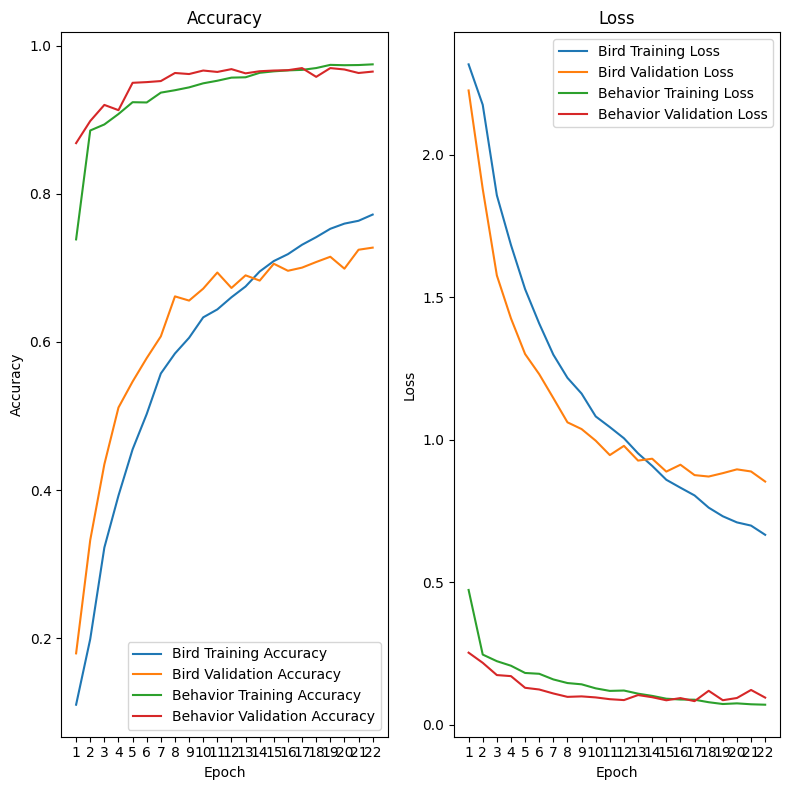

136/136 [==============================] - 25s 187ms/step - loss: 0.9745 - output_bird_loss: 0.5846 - output_behavior_loss: 0.0470 - output_bird_accuracy: 0.8098 - output_behavior_accuracy: 0.9834
Train Accuracy for Bird: 0.81
Train Accuracy for Behavior: 0.98
34/34 [==============================] - 6s 182ms/step - loss: 1.3122 - output_bird_loss: 0.8749 - output_behavior_loss: 0.0944 - output_bird_accuracy: 0.7015 - output_behavior_accuracy: 0.9630
Validation Accuracy for Bird: 0.7
Validation Accuracy for Behavior: 0.96
43/43 [==============================] - 8s 180ms/step - loss: 1.2892 - output_bird_loss: 0.8489 - output_behavior_loss: 0.0974 - output_bird_accuracy: 0.7205 - output_behavior_accuracy: 0.9638
Test Accuracy for Bird: 0.72
Test Accuracy for Behavior: 0.96
34/34 [==============================] - 6s 181ms/step


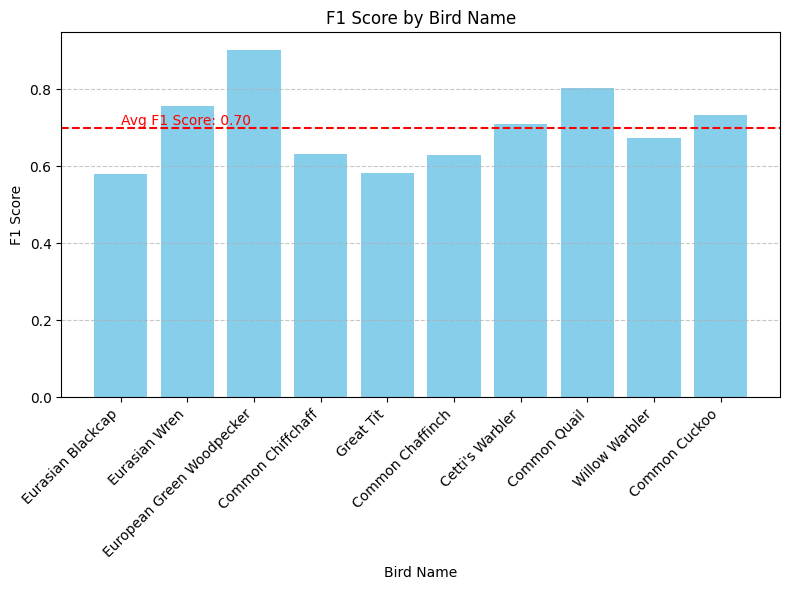

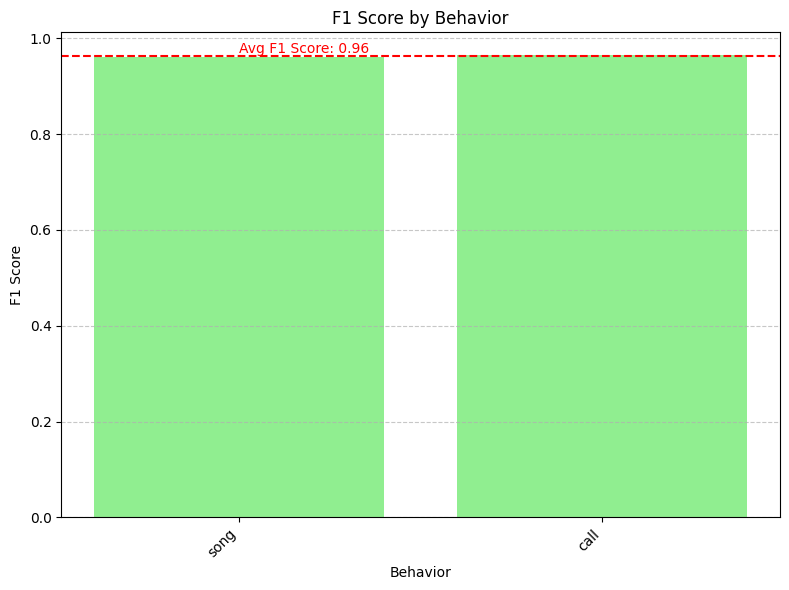

In [ ]:
model_eval(model, train_data, val_data, valgen_df, testgen_df, index_to_name, index_to_name_b,
               epochs=30, title='Model', test=False)

### **5.a Trying a different architecture to attain an 85% accuracy in bird type classification**


Note that though the model outperforms the previous, there are a lot more parameters. The model was trained with additional 50 samples of augmented call and song data for all birds and behaviors. As suspected, this evened out the f1 score distribution and raised the performance for all classes. Using the original final model architecture (`optimized_model2`), the accuracy reached 80% with the additional samples. In order to breach the 85% accuracy threshold, the architecture had to be adjusted.



In [ ]:
model = load_model(base_path + '/sandra_wip/model_84.keras')

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 128, 128, 64)         6400      ['input_11[0][0]']            
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_36[0][0]']           
                                                                                                  
 max_pooling2d_33 (MaxPooli  (None, 64, 64, 64)           0         ['leaky_re_lu_6[0][0]']       
 ng2D)                                                                                     

136/136 [==============================] - 27s 185ms/step - loss: 0.5035 - output_bird_loss: 0.4677 - output_behavior_loss: 0.0358 - output_bird_accuracy: 0.8495 - output_behavior_accuracy: 0.9893
Train Accuracy for Bird: 0.85
Train Accuracy for Behavior: 0.99
34/34 [==============================] - 7s 209ms/step - loss: 0.5023 - output_bird_loss: 0.4652 - output_behavior_loss: 0.0371 - output_bird_accuracy: 0.8549 - output_behavior_accuracy: 0.9898
Validation Accuracy for Bird: 0.85
Validation Accuracy for Behavior: 0.99
43/43 [==============================] - 8s 192ms/step - loss: 0.4919 - output_bird_loss: 0.4616 - output_behavior_loss: 0.0303 - output_bird_accuracy: 0.8499 - output_behavior_accuracy: 0.9900
Test Accuracy for Bird: 0.85
Test Accuracy for Behavior: 0.99
34/34 [==============================] - 6s 186ms/step


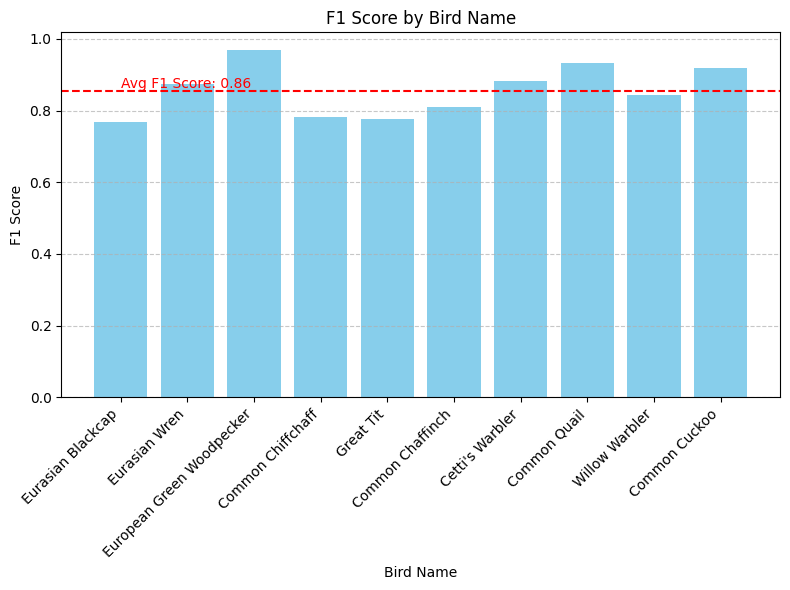

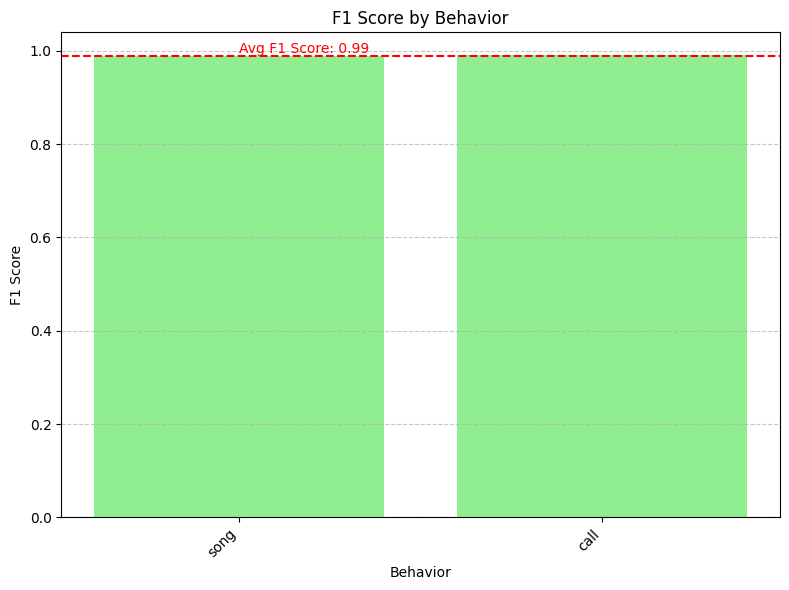

In [ ]:
model_eval(model, train_data, val_data,
               valgen_df, testgen_df, index_to_name, index_to_name_b, epochs=30, title='Model',training=False)

### **6. Summarize Findings & Future Work**

In the process of adding more data, parameters had to be adjusted for call data, which exhibits lower sound frequencies. Using the default settings of song data on the call samples resulted in spectrograms with white, horizontal lines that even caused completely blank images in some cases. This also occurred for the top call and song bird classification task in the previous section. Examples are shown below. The settings were now updated for call to:

`mel_fmin = 1500` <br>
`mel_fmax = 7000`

When oversampling, small variations in the `mel_fmin` and `mel_fmax` could already result in white horizontal lines, thus the allowed deviation range for creating new samples was reduced to `mel_range = 0.01`. Instead, the Epsilon value beneath which sound is considered noise was varied more aggressively (the current oversampled data used `epsilon_range = 0.5`, yet 0.9 produced even more distinct results, but with more exceptions that could not render). It is an effective method to create new samples and is more fitting than the options provided by the data generator. Further research on the possible frequency ranges per bird type and behavior, as well as other hyperparameters in mel spectrograms and audio processing, would improve the oversampling/augmenting phase. In order to remove the white lines, very fine tuning was necessary for `mel_fmin` and `mel_fmax`; a `mel_fmin` of 10 with `mel_fmax = 8000` resulted in only one or two lines, while increasing `mel_fmin` to 1500 and decreasing `mel_fmax` to 7000 finally removed them. Nevertheless, due to varying the `mel_range`, there are still a few smaples with a white line. The image below shows how effective increasing the `epsilon_range` is for sample generation and the issue with `mel_range`.

Regarding the model performance for double classification, the original results are:

- Train Accuracy for Bird: 0.81
- Train Accuracy for Behavior: 0.98
- Validation Accuracy for Bird: 0.7
- Validation Accuracy for Behavior: 0.96
- Test Accuracy for Bird: 0.72
- Test Accuracy for Behavior: 0.96

while the behavior type is classified with high accuracy, the bird type classification performs worse. There is a trade-off in performance between classes when using one model for different tasks. There is also more overfitting than our previous results, though this may be because not enough augmentation was used (since using new data was the primary objective).

It appears that using two seperate networks would give the best results. An argument against using seperate networks would be that, since calls and songs differ in frequencies, their spectrograms are different for each bird type and require both labels. Due to time constraints, the model could not be tested on both call and song data without behavior labelling, yet this would be a valuable next step to verify whether a second class is necessary in the first place. However,the model has nigh perfect f1 scores for the behaviors; there is likely a distinct difference in them and a model without additional behavior information would struggle to classify both song and call.

Fine-tuning this model would be more resource efficient than separate models. For instance, having seperate fully connected layers instead of shared ones may achieve a similar effect to seperate models, without increasing the parameters as much as a second model.

A positive takeaway for the bird type classification in this joint classification task is that, while the F1 score decreased for bird types, it is still above 50% for all bird categories, meaning the model has a better than chance success at identifying positive cases correctly and avoiding false positives. The Common Quail and European Green Woodpecker have the highest F1 scores. While these bird classes do not have the highest absolute number of oversampled data for either call or song, they have the highest joint number of oversampled data. This indicates that oversampling works well as an augmentation technique if it is done for both behaviors equally. For instance, the Eurasian Blackcap has no oversampling for song (only call), and it has the lowest F1 score. To test this, we increased all call and song samples by 50 extra augmented samples. As a result, the F1 score imrpoved to 86% with the same accuracy scores for train, test and validation of 85%, which just manages to hit our specified target accuracy. The F1 scores are more uniformly distributed across bird types compared to the initial results.

Apart from the above, the research direction of this project would also benefit from 1) further researched pre-processing/augmentation methods to account for more bird classes in the future, where the imbalance will only grow and samples will be few, 2) additional inputs for geographic information or other variables in the data, 3) making use of the bird background noise column to furnish the top 3 likeliest birds instead, and 4) fast, efficient processing and real-time inference capabilities (many Gigabytes of storage were required for audio and spectrograms, much was needed in compute resources; being able to retrain the model frequently with new Xeno Canto data would be useful, etc.). Scalability and cost efficiency should be considered.

Finally, there are audio-specific denoising techniques that would prove useful, such as the signal envelope function.



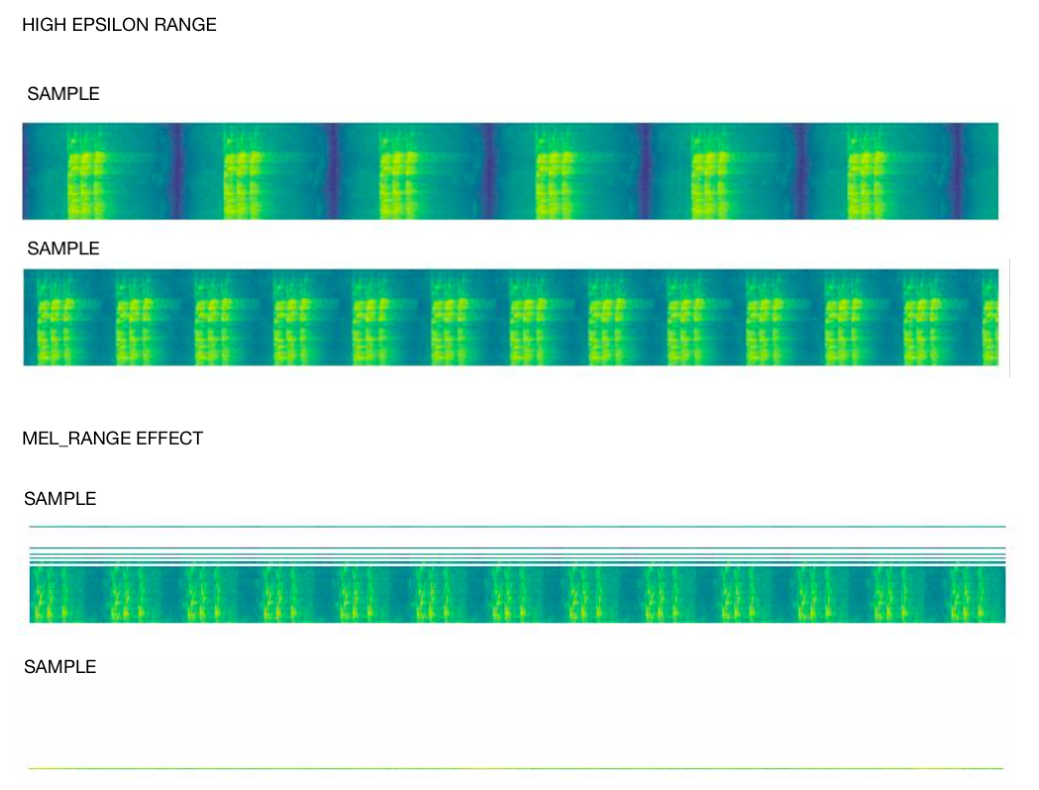

In [ ]:
img = mpimg.imread(os.path.join(base_path_109b_folder,'figures/augmentation.png'))
plt.figure(figsize=(14, 10))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()
